# 3. Cluster Analysis

This notebook performs a cluster analysis on the data set df_trips based on various parameters and also includes clustering based on weather and spatial features.

**Task** <br>
Getting a deep understanding of how customers use your mobility service is crucial.
As an example, for marketing purposes, or managerial decisions. One widely adopted approach to
understand customers’ behavior is to find prevalent usage/trip clusters. Tasks: Based on the taxi trip
patterns, can you identify clusters of trip types and/or customer types? How would you label these
clusters? Methods: Identify clusters with soft-clustering and visualize your results. Compare your
results to a hard-clustering method of your choice. You can use additional features like “distance to city
center”, expressive hourly resolutions (e.g., “bar hours”, “morning commuting”), or even land-use/POI
data.
Furthermore, can you identify spatial hot spots for trip demand using Gaussian Mixture Models (i.e.,
using Spatial Kernel Density Estimation)?

**Cluster analyses**
1. Trips-based  cluster analysis:
    - Trip clustering based on trips dataframe and a trip based feature selection
    - Trip/Customer clustering based on customer specific attributes as payment methods to identify customer behaviors
2. Weather-based cluster analysis:
    - Clustering based on trip data enhanced by weather data
3. Spatial/Hexagon-based cluster analysis:
    - Hexagon demand clustering
    - Hexagon demand clustering with a separation by weekday/weekend
    - Hexagon hotspot clustering to identify hotspot areas

**Notebook Outline**
- Initialization
    - Imports
    - Defines
    - Helper Methods   
- Data loading and preparation
    - Trip data
    - Weather data
    - POI data
- Cluster Analysis
    - Trip-based clustering
    - Weather-based clustering
    - Hexagon-based clustering
- Conclusion

# Initialization

## Imports
Importing the needed packages.

In [1]:
import vaex
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import folium
import seaborn as sns

import geopandas as gpd

import h3
from shapely.geometry.polygon import Polygon
from shapely.geometry.point import Point

from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

In [2]:
# surpress warnings
import warnings
warnings.filterwarnings('ignore')

## Defines

In [3]:
# hex resolution
HEX_RES = 9
# test mode -> reduces the number of samples to process
TEST_MODE = False

## Helper Methods
Collection of helper methods for various repetitive tasks. The collection is structured by the category of the method as followed:
1. Data Cleaning and preparation
2. Clustering Helper
3. Data Visualization and Evaluation


### 1. Data cleaning and preparation
Collection of methods used for data cleaning on all datasets. The main functionality is to remove Nan values and to replace outliers in the dataset.

In [4]:
def outlier_thresholds(dataframe, feature):
    """
    Method to find outlier in a feature
    Returns the lower and upper limit
    """
    lower_quantile = dataframe[feature].quantile(0.10)
    upper_quantile = dataframe[feature].quantile(0.90)
    interquantile_range = upper_quantile - lower_quantile
    up_limit  = upper_quantile + 1.5 * interquantile_range
    low_limit = lower_quantile - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, feature):
    """
    Method to replace outlier in a feature.
    It replaces outliers by the lower or upper limit.    
    """
    low_limit, up_limit = outlier_thresholds(dataframe, feature)
    dataframe.loc[(dataframe[feature] < low_limit), feature] = low_limit
    dataframe.loc[(dataframe[feature] > up_limit), feature] = up_limit

def remove_all_outliers(dataframe):
    """
    Method to iterate over all columns of a dataframe to replace all outliers
    """
    for col in dataframe.select_dtypes([np.number]).columns:
        dataframe[col].fillna(0, inplace=True)
        replace_with_thresholds(dataframe, col)

In [5]:
def scale_df(dataframe):
    """
    Method to scale a given dataframe. The return is the scaled dataframe.
    """
    scaler = StandardScaler()
    scaler.fit(dataframe)
    dataframe_scaled = scaler.transform(dataframe)

    scaled_df = pd.DataFrame(dataframe_scaled, columns = dataframe.columns, index = dataframe.index)

    return scaled_df

### 2. Clustering Helper
Collection of methods to encapsulate repetitive tasks during the clustering (e.g. Scaling, GridSearch, fitting, prediction)

In [6]:
def gridSearch(scaled_dataframe, n_clusters_max = 6):
    """
    Method that performs a grid search with the given model and plots the results.
    """
    clusters = []
    losses = []

    for k in range(n_clusters_max):
        model = KMeans(n_clusters = k + 1, n_init=10, init="k-means++", random_state=42)
        model.fit(scaled_dataframe)
        clusters.append(k+1)
        losses.append(model.inertia_)
        
    # plot grid search result
    plt.plot(clusters, losses)
    plt.ylabel("Loss")
    plt.xlabel("Number of clusters")
    plt.show()

In [7]:
def fit_and_predict(model, scaled_dataframe, dataframe):
    """
    Method that performs the fitting and prediction based on a given model and dataframe
    """
    model.fit(scaled_dataframe)
    dataframe[f'cluster_{model.__class__.__name__}'] =  model.predict(scaled_dataframe)

### 3. Data Visualization and Evaluation
Collection of methods to visualize the dataframe and the clustering results.

In [8]:
def plt_corr(dataframe):
    """
    Method to plot a correlation matrix for the dataset.
    """
    base_df_corr = dataframe.corr()
    mask = np.triu(np.ones_like(base_df_corr, dtype=bool))
    f = plt.figure()
    f.set_figwidth(20)
    f.set_figwidth(20)
    sns.heatmap(base_df_corr, annot = True, vmax= 1, vmin= -1, center=0, cmap='vlag', mask = mask)
    plt.show()

In [9]:
def feature_distribution(dataframe, cluster_column):
    """
    Method that returns a evaluation of each cluster including mean and std of each feature, the number of elements per cluster and the most frequent value per feature
    """
    # seperate feature columns
    feature_cols = list(filter(lambda x: not x.startswith('cluster'), dataframe.columns))
    # aggregate by cluster col
    feature_distribution_df = dataframe.groupby(cluster_column).agg(['mean', 'std'])[feature_cols]
    # add sizes
    feature_distribution_df["cluster_size"] = dataframe.groupby(cluster_column).size()
    # add value with the highest share
    value_frequencies =  dataframe.groupby(cluster_column).agg(lambda x:x.value_counts().index[0])
    for col in feature_cols:
        feature_distribution_df[f'first_{col}'] = value_frequencies[col]
    
    return feature_distribution_df

In [10]:
def plt_violins(dataframe):
        """
        Method to plot violin charts of the clustering results including a bar plot of the cluster sizes.
        """
 
        cluster_cols = list(filter(lambda x: x.startswith('cluster'), dataframe.columns))
        feature_cols = list(filter(lambda x: not x.startswith('cluster'), dataframe.columns))

        fig, axes = plt.subplots(nrows = len(feature_cols) + 1, ncols = len(cluster_cols), figsize = (20,15))

        # iterate over all input features to plot the value distribution across the clusters  
        for cluster_id, cluster_col in enumerate(cluster_cols):
                for feature_id, feat in enumerate(feature_cols):
                        sns.violinplot(ax = axes[feature_id, cluster_id], x=dataframe[cluster_col], y=dataframe[feat], data=dataframe)
                        axes[feature_id, cluster_id].set_title(f'{cluster_col} - {feat}')
                # add cluster size to the plot
                cluster_size = dataframe.groupby(cluster_col).size()
                axes[len(feature_cols), cluster_id].bar(cluster_size.index, cluster_size)
                axes[len(feature_cols), cluster_id].set_title(f'{cluster_col} - Cluster Sizes')

        fig.tight_layout()
        plt.show()

In [11]:
def plt_cluster_size(dataframe):
        """
        Method to plot a bar plot of the cluster sizes.
        """
 
        cluster_cols = list(filter(lambda x: x.startswith('cluster'), dataframe.columns))
        fig, axes = plt.subplots(nrows = 1, ncols = len(cluster_cols), figsize = (20,5))

        # iterate over all input features to plot the value distribution across the clusters  
        for cluster_id, cluster_col in enumerate(cluster_cols):
                # add cluster size to the plot
                cluster_size = dataframe.groupby(cluster_col).size()
                axes[cluster_id].bar(cluster_size.index, cluster_size)
                axes[cluster_id].set_title(f'{cluster_col} - Cluster Sizes')

        fig.tight_layout()
        plt.show()

In [12]:
def hex_to_map(dataframe):
    """
        Method to plot a map per cluster.
    """
    # create new dataframe with based on all cluster columns
    cluster_cols = list(filter(lambda x: x.startswith('cluster'), dataframe.columns))    
    map_df = dataframe[cluster_cols]

    #convert hex to polygon
    map_df['hex'] = dataframe.index
    map_df = map_df[map_df.hex != 'None']
    map_df['geometry'] = map_df['hex'].apply(lambda id: Polygon(h3.cell_to_boundary(id, geo_json=True)))  
    

    # create geopandas dataframe
    map_gdf = gpd.GeoDataFrame(map_df[['geometry'] + cluster_cols ], crs='EPSG:4326')
    
    map = None

    for col in cluster_cols:
        map = map_gdf.explore(m = map, column = col, name = col)
    
    folium.LayerControl().add_to(map)
    
    return map    

In [13]:
 def plt_temporal_patterns(dataframe, no_cluster):
    """
        Method to plot temporal patterns.
    """
    cluster_cols = list(filter(lambda x: x.startswith('cluster'), dataframe.columns))
   
    fig, ax = plt.subplots(nrows = len(cluster_cols), ncols = no_cluster, figsize=(20,16))
    
    for cluster in range(0, no_cluster):
        for idx, cluster_col in enumerate(cluster_cols):
            dataframe[dataframe[cluster_col] == cluster].drop(columns = cluster_cols).T.plot(ax=ax[idx, cluster], color='#8f3371', alpha=0.05)
            dataframe[dataframe[cluster_col] == cluster].drop(columns = cluster_cols).mean(numeric_only=True).T.plot(ax=ax[0, cluster], color = '#8f3371', alpha=1)
            ax[idx, cluster].get_legend().remove()
            ax[idx, cluster].set_title(f'{cluster_col} Cluster: {cluster}')
            ax[idx, cluster].set_xlim([0,23])
            ax[idx, cluster].set_xticks(np.arange(0,23))
    
    for idx, cluster_col in enumerate(cluster_cols):
        ax[idx, 0].set_ylabel('Number of Trips')

    plt.show()

# Data loading and preparation

1. Loading the data from different sources:
    - trip data
    - weather data
    - poi data
2. Selecting the relevant features and add additional features

## Trip data

In [14]:
# Load trip data from vaex df data/trips/trips_prepared.hdf
df_trips = vaex.open('data/trips/trips_prepared.hdf')

# for testing with reduced lines
if TEST_MODE:
    df_trips = df_trips.sample(n=100000, random_state=42)

In [15]:
df_trips.info()

#### Feature selection and conversion to pandas

In [16]:
# feature selection

features = ['ts_start_1_hour', 'start_month', 'start_weekday', 'start_weekday_sin', 'start_weekday_cos', 'start_1_hour', 'start_1_hour_sin', 'start_1_hour_cos', 'Trip Seconds', 'Trip Total', f'pickup_hex_{HEX_RES}', f'dropoff_hex_{HEX_RES}', 'Payment Type_Cash', 'Payment Type_Credit Card']

# convert vaex to pandas dataframe
df_trips = df_trips[features].to_pandas_df()

### Data cleaning

In [17]:
remove_all_outliers(df_trips)

In [18]:
df_trips = df_trips[df_trips[f'pickup_hex_{HEX_RES}']  != 'None']
df_trips = df_trips[df_trips[f'dropoff_hex_{HEX_RES}'] != 'None']

### Calculation of additional features
Calculation of hexagon based features as the distance to the center (location with the highest amount of ride starts) for Pickup and Dropoff and the direction of the ride (is the ride going to or away from the center). The measure is the number of hexagons.

In [19]:
# defining the city center by selecting the hexagon with the most pickups as center
center_hex = df_trips[f'pickup_hex_{HEX_RES}'].value_counts().idxmax()

print(f'Center hexagon: {center_hex}')

# calculate distances. Invalid hexagons result in 0.
df_trips['dist_center_pickup']  = df_trips.apply(lambda row: h3.grid_distance(row[f'pickup_hex_{HEX_RES}'] if h3.is_valid_cell(row[f'pickup_hex_{HEX_RES}']) else center_hex, center_hex), axis=1)
df_trips['dist_center_dropoff'] = df_trips.apply(lambda row: h3.grid_distance(row[f'dropoff_hex_{HEX_RES}'] if h3.is_valid_cell(row[f'dropoff_hex_{HEX_RES}']) else center_hex, center_hex), axis=1)

# direction -> negative values represent trips going away from the center whereas positive values represent trips to the center.
df_trips['direction']           = df_trips['dist_center_dropoff'] - df_trips['dist_center_pickup']                                                                    

Center hexagon: 892664c1a8bffff


Calculation of additional time-based features

In [20]:
# is_weekend: 1 for week end, 0 for weekdays
df_trips['is_weekend'] = np.where(df_trips['start_weekday'] >= 5, 1, 0)

In [21]:
df_trips

ts_start_1_hour  start_month  start_weekday  start_weekday_sin  \
0        2014-05-17 10:00:00          5.0              5          -0.974928   
2        2014-05-03 23:00:00          5.0              5          -0.974928   
3        2014-05-17 01:00:00          5.0              5          -0.974928   
5        2014-05-14 09:00:00          5.0              2           0.974928   
6        2014-05-04 03:00:00          5.0              6          -0.781831   
...                      ...          ...            ...                ...   
37395431 2014-04-03 20:00:00          4.0              3           0.433884   
37395432 2014-05-13 23:00:00          5.0              1           0.781831   
37395433 2014-05-14 12:00:00          5.0              2           0.974928   
37395434 2014-05-14 12:00:00          5.0              2           0.974928   
37395435 2014-05-13 23:00:00          5.0              1           0.781831   

          start_weekday_cos  start_1_hour  start_1_hour_sin  start_1_hour_cos  \
0                 -0.222521            10      5.000000e-01         -0.866025   
2                 -0.222521            23     -2.588190e-01          0.965926   
3                 -0.222521             1      2.588190e-01          0.965926   
5                 -0.222521             9      7.071068e-01         -0.707107   
6                  0.623490             3      7.071068e-01          0.707107   
...                     ...           ...               ...               ...   
37395431          -0.900969            20     -8.660254e-01          0.500000   
37395432           0.623490            23     -2.588190e-01          0.965926   
37395433          -0.222521            12      1.224647e-16         -1.000000   
37395434          -0.222521            12      1.224647e-16         -1.000000   
37395435           0.623490            23     -2.588190e-01          0.965926   

          Trip Seconds  Trip Total     pickup_hex_9    dropoff_hex_9  \
0               1080.0       18.95  892664c1acfffff  892664c1617ffff   
2                720.0       11.45  892664c1e4fffff  892664c1e33ffff   
3                480.0       11.85  892664c114fffff  892664c163bffff   
5                180.0        5.05  892664d8ccfffff  892664d88bbffff   
6                840.0        9.85  892664c13afffff  892664c1a07ffff   
...                ...         ...              ...              ...   
37395431         900.0       11.25  892664c1607ffff  892664cac3bffff   
37395432         540.0       15.40  892664c1ecfffff  892664c1607ffff   
37395433         240.0        9.75  892664c1a8bffff  892664cad77ffff   
37395434         360.0        5.05  892664c1ed7ffff  892664c1e8fffff   
37395435         840.0       13.70  892664c1e2fffff  892664c13cfffff   

          Payment Type_Cash  Payment Type_Credit Card  dist_center_pickup  \
0                       1.0                       0.0                   2   
2                       0.0                       1.0                   5   
3                       0.0                       1.0                  12   
5                       1.0                       0.0                  49   
6                       1.0                       0.0                  10   
...                     ...                       ...                 ...   
37395431                1.0                       0.0                  25   
37395432                0.0                       1.0                   7   
37395433                0.0                       1.0                   0   
37395434                1.0                       0.0                   8   
37395435                0.0                       1.0                   3   

          dist_center_dropoff  direction  is_weekend  
0                          26         24           1  
2                           5          0           1  
3                          24         12           1  
5                          40         -9           0  
6                         

## Weather data

In [22]:
df_weather = pd.read_pickle('data/weather.pickle')

In [23]:
df_weather.columns

Index(['Temperature', 'Humidity', 'Wind Speed', 'Precip.', 'cloud', 'rain',
       'Fair', 'Fog', 'Snow', 'T-Storm', 'Thunder'],
      dtype='object')

In [24]:
#weather_attributes = ['Temperature', 'Humidity', 'Wind Speed', 'Precip.', 'cloud', 'rain', 'Fair', 'Fog', 'Snow', 'T-Storm', 'Thunder']
weather_attributes = ['Temperature', 'Precip.', 'cloud']

df_weather = df_weather[weather_attributes]

### Data cleaning

In [25]:
remove_all_outliers(df_weather)

In [26]:
df_weather

Temperature  Precip.  cloud
datetime                                        
2014-01-01 00:00:00        -10.0      0.0    3.0
2014-01-01 01:00:00         -8.9      0.0    3.0
2014-01-01 02:00:00         -8.3      0.0    3.0
2014-01-01 03:00:00         -7.8      0.0    3.0
2014-01-01 04:00:00         -7.2      0.0    3.0
...                          ...      ...    ...
2014-12-31 19:00:00         -7.2      0.0    0.0
2014-12-31 20:00:00         -7.2      0.0    0.0
2014-12-31 21:00:00         -6.7      0.0    0.0
2014-12-31 22:00:00         -6.7      0.0    0.0
2014-12-31 23:00:00         -6.7      0.0    0.0

[8760 rows x 3 columns]

## POI data

In [27]:
df_poi = pd.read_pickle('data/poi/poi_prepared.pickle')

In [28]:
df_poi

amenity  \
osmid                         
258490031           parking   
269449042  parking_entrance   
269450074  parking_entrance   
269688947          post_box   
270863340  parking_entrance   
...                     ...   
13621412                NaN   
13621413                NaN   
13621414                NaN   
15910906                NaN   
15910907                NaN   

                                                    geometry name  \
osmid                                                               
258490031                         POINT (-87.64385 41.95123)  NaN   
269449042                         POINT (-87.61506 41.85869)  NaN   
269450074                         POINT (-87.58421 41.79174)  NaN   
269688947                         POINT (-87.77220 42.00407)  NaN   
270863340                         POINT (-87.61564 41.86421)  NaN   
...                                                      ...  ...   
13621412   POLYGON ((-87.66859 41.91735, -87.66895 41.917...  NaN   
13621413   POLYGON ((-87.66793 41.91671, -87.66797 41.916...  NaN   
13621414   POLYGON ((-87.66801 41.91728, -87.66800 41.917...  NaN   
15910906   POLYGON ((-87.62624 41.87979, -87.62623 41.879...  NaN   
15910907   POLYGON ((-87.62610 41.87984, -87.62610 41.880...  NaN   

                   category   latitude  longitude public_transport wheelchair  \
osmid                                                                           
258490031           parking  41.951227 -87.643847              NaN        NaN   
269449042           parking  41.858689 -87.615058              NaN        NaN   
269450074           parking  41.791742 -87.584208              NaN        NaN   
269688947             other  42.004073 -87.772198              NaN        NaN   
270863340           parking  41.864208 -87.615638              NaN        NaN   
...                     ...        ...        ...              ...        ...   
13621412   public_transport  41.917203 -87.668448         platform        NaN   
13621413   public_transport  41.917215 -87.668182         platform        NaN   
13621414   public_transport  41.917277 -87.668066         platform        NaN   
15910906   public_transport  41.879543 -87.626201         platform         no   
15910907   public_transport  41.879567 -87.626064         platform         no   

                     hex_7            hex_8            hex_9  \
osmid                                                          
258490031  872664c14ffffff  882664c145fffff  892664c144fffff   
269449042  872664c1bffffff  882664c1b1fffff  892664c1b03ffff   
269450074  872664cc5ffffff  882664cc59fffff  892664cc583ffff   
269688947  872664d9effffff  882664d9e1fffff  892664d9e0fffff   
270863340  872664c1bffffff  882664c1bdfffff  892664c1bc7ffff   
...                    ...              ...              ...   
13621412   872664c12ffffff  882664cac9fffff  892664cac93ffff   
13621413   872664c12ffffff  882664cac9fffff  892664cac93ffff   
13621414   872664c12ffffff  882664cac9fffff  892664cac93ffff   
15910906   872664c1affffff  882664c1a9fffff  892664c1a87ffff   
15910907   872664c1affffff  882664c1a9fffff  892664c1a87ffff   

                                                       pol_7  \
osmid                                                          
258490031  POLYGON ((-87.63414405293 41.96445315471353, -...   
269449042  POLYGON ((-87.61820944356228 41.8710984903598,...   
269450074  POLYGON ((-87.5937067068291 41.798228672497444...   
269688947  POLYGON ((-87.7773181551225 42.01982017726515,...   
270863340  POLYGON ((-87.61820944356228 41.8710984903598,...   
...                                                      ...   
13621412   POLYGON ((-87.6723729663648 41.93963771855481,...   
13621413   POLYGON ((-87.6723729663648 41.93963771855481,...   
13621414   POLYGON ((-87.6723729663648 41.93963771855481,...   
15910906   POLYGON ((-87.63912440648137 41.88713767856642...   
15910907   POLYGON ((-87.63912440648137 41.88713767856642...   

In [29]:
df_poi_category = df_poi.groupby(by=[ 'category', f'hex_{HEX_RES}']).count()['geometry'].unstack(0).fillna(0)
df_poi_category

category         bicycle_parking  bicycle_rental  bicycle_repair_station  \
hex_9                                                                      
89266419027ffff              0.0             0.0                     0.0   
8926641902bffff              0.0             0.0                     0.0   
8926641902fffff              0.0             0.0                     0.0   
89266419037ffff              0.0             0.0                     0.0   
89266419073ffff              0.0             0.0                     0.0   
...                          ...             ...                     ...   
89275936dc7ffff              0.0             0.0                     0.0   
89275936dcbffff              0.0             0.0                     0.0   
89275936dcfffff              0.0             0.0                     0.0   
89275936dd3ffff              0.0             0.0                     0.0   
89275936ddbffff              0.0             0.0                     0.0   

category         car_rental  car_sharing  children  culture  education  \
hex_9                                                                    
89266419027ffff         0.0          0.0       0.0      0.0        0.0   
8926641902bffff         0.0          0.0       0.0      0.0        0.0   
8926641902fffff         0.0          0.0       0.0      0.0        0.0   
89266419037ffff         0.0          0.0       0.0      0.0        0.0   
89266419073ffff         0.0          0.0       0.0      0.0        0.0   
...                     ...          ...       ...      ...        ...   
89275936dc7ffff         0.0          0.0       0.0      0.0        0.0   
89275936dcbffff         0.0          0.0       0.0      0.0        0.0   
89275936dcfffff         0.0          0.0       0.0      0.0        0.0   
89275936dd3ffff         0.0          0.0       0.0      0.0        0.0   
89275936ddbffff         0.0          0.0       0.0      0.0        1.0   

category         finance  fuel  ...  health  nightlife  other  parking  \
hex_9                           ...                                      
89266419027ffff      0.0   0.0  ...     0.0        0.0    0.0      4.0   
8926641902bffff      0.0   0.0  ...     0.0        0.0    0.0      3.0   
8926641902fffff      0.0   0.0  ...     0.0        0.0    0.0      1.0   
89266419037ffff      0.0   0.0  ...     0.0        0.0    0.0      2.0   
89266419073ffff      0.0   0.0  ...     0.0        0.0    0.0      1.0   
...                  ...   ...  ...     ...        ...    ...      ...   
89275936dc7ffff      0.0   0.0  ...     0.0        0.0    0.0      0.0   
89275936dcbffff      0.0   0.0  ...     0.0        0.0    0.0      0.0   
89275936dcfffff      0.0   0.0  ...     0.0        0.0    1.0      0.0   
89275936dd3ffff      0.0   0.0  ...     0.0        0.0    0.0      0.0   
89275936ddbffff      0.0   0.0  ...     0.0        0.0    0.0      0.0   

category         place_of_worship  police  public_transport  sports  taxi  \
hex_9                                                                       
89266419027ffff               0.0     0.0               0.0     0.0   0.0   
8926641902bffff               0.0     0.0               0.0     0.0   0.0   
8926641902fffff               0.0     0.0               0.0     0.0   0.0   
89266419037ffff               0.0     0.0               0.0     0.0   0.0   
89266419073ffff               0.0     0.0               0.0     0.0   0.0   
...                           ...     ...               ...     ...   ...   
89275936dc7ffff               0.0     0.0               1.0     0.0   0.0   
89275936dcbffff               0.0     0.0               2.0     0.0   0.0   
89275936dcfffff               0.0     0.0               1.0     0.0   0.0   
89275936dd3ffff               0.0     0.0               1.0     0.0   0.0   
89275936ddbffff               1.0     0.0               0.0     0.0   0.0   

category         water_transport  
hex_9                             
89266419027ff

# Cluster Analysis

The following chapter performs and evaluates several cluster analyses. 

Our choice was to contrast Gaussian Mixture Models, a form of soft clustering, with k-means, which adopts a hard clustering approach. For k-means, we used the k-means++ initialization technique to mitigate issues tied to local optima. Both implementations build on the scikit-learn library. This selection was driven by their performance and our familiarity with these models. Particularly, we sought methods that were straightforward to apply, interpret, and compare.

This method selection remains consistent throughout the entirety of the clustering section, serving the purpose of maintaining coherence.

The structure is as follows:
1. Trips-based  cluster analysis:
    - Trip clustering based on trips dataframe and a trip based feature selection
    - Trip/Customer clustering based on customer specific attributes as payment methods to identify customer behaviors
2. Weather-based cluster analysis:
    - Clustering based on trip data enhanced by weather data
3. Spatial/Hexagon-based cluster analysis:
    - Hexagon demand clustering
    - Hexagon demand clustering with a separation by weekday/weekend
    - Hexagon hotspot clustering to identify hotspot areas

## Trip-based clustering

### Trip clustering

Clustering based on trip information as direction and time.

In [30]:
df_trips

ts_start_1_hour  start_month  start_weekday  start_weekday_sin  \
0        2014-05-17 10:00:00          5.0              5          -0.974928   
2        2014-05-03 23:00:00          5.0              5          -0.974928   
3        2014-05-17 01:00:00          5.0              5          -0.974928   
5        2014-05-14 09:00:00          5.0              2           0.974928   
6        2014-05-04 03:00:00          5.0              6          -0.781831   
...                      ...          ...            ...                ...   
37395431 2014-04-03 20:00:00          4.0              3           0.433884   
37395432 2014-05-13 23:00:00          5.0              1           0.781831   
37395433 2014-05-14 12:00:00          5.0              2           0.974928   
37395434 2014-05-14 12:00:00          5.0              2           0.974928   
37395435 2014-05-13 23:00:00          5.0              1           0.781831   

          start_weekday_cos  start_1_hour  start_1_hour_sin  start_1_hour_cos  \
0                 -0.222521            10      5.000000e-01         -0.866025   
2                 -0.222521            23     -2.588190e-01          0.965926   
3                 -0.222521             1      2.588190e-01          0.965926   
5                 -0.222521             9      7.071068e-01         -0.707107   
6                  0.623490             3      7.071068e-01          0.707107   
...                     ...           ...               ...               ...   
37395431          -0.900969            20     -8.660254e-01          0.500000   
37395432           0.623490            23     -2.588190e-01          0.965926   
37395433          -0.222521            12      1.224647e-16         -1.000000   
37395434          -0.222521            12      1.224647e-16         -1.000000   
37395435           0.623490            23     -2.588190e-01          0.965926   

          Trip Seconds  Trip Total     pickup_hex_9    dropoff_hex_9  \
0               1080.0       18.95  892664c1acfffff  892664c1617ffff   
2                720.0       11.45  892664c1e4fffff  892664c1e33ffff   
3                480.0       11.85  892664c114fffff  892664c163bffff   
5                180.0        5.05  892664d8ccfffff  892664d88bbffff   
6                840.0        9.85  892664c13afffff  892664c1a07ffff   
...                ...         ...              ...              ...   
37395431         900.0       11.25  892664c1607ffff  892664cac3bffff   
37395432         540.0       15.40  892664c1ecfffff  892664c1607ffff   
37395433         240.0        9.75  892664c1a8bffff  892664cad77ffff   
37395434         360.0        5.05  892664c1ed7ffff  892664c1e8fffff   
37395435         840.0       13.70  892664c1e2fffff  892664c13cfffff   

          Payment Type_Cash  Payment Type_Credit Card  dist_center_pickup  \
0                       1.0                       0.0                   2   
2                       0.0                       1.0                   5   
3                       0.0                       1.0                  12   
5                       1.0                       0.0                  49   
6                       1.0                       0.0                  10   
...                     ...                       ...                 ...   
37395431                1.0                       0.0                  25   
37395432                0.0                       1.0                   7   
37395433                0.0                       1.0                   0   
37395434                1.0                       0.0                   8   
37395435                0.0                       1.0                   3   

          dist_center_dropoff  direction  is_weekend  
0                          26         24           1  
2                           5          0           1  
3                          24         12           1  
5                          40         -9           0  
6                         

In [31]:
df_trips.columns

Index(['ts_start_1_hour', 'start_month', 'start_weekday', 'start_weekday_sin',
       'start_weekday_cos', 'start_1_hour', 'start_1_hour_sin',
       'start_1_hour_cos', 'Trip Seconds', 'Trip Total', 'pickup_hex_9',
       'dropoff_hex_9', 'Payment Type_Cash', 'Payment Type_Credit Card',
       'dist_center_pickup', 'dist_center_dropoff', 'direction', 'is_weekend'],
      dtype='object')

Feature selection

In [32]:
# Clustering features
trips_clust_feat     = ['is_weekend',  'start_1_hour', 'Trip Seconds', 'dist_center_pickup', 'dist_center_dropoff', 'direction']
# Encoded features
trips_enc_clust_feat = ['is_weekend',  'start_1_hour_sin', 'start_1_hour_cos', 'Trip Seconds', 'dist_center_pickup', 'dist_center_dropoff', 'direction']

df_trips_clust = df_trips[trips_clust_feat]
df_trips_enc_clust = df_trips[trips_enc_clust_feat]

Scale encoded dataframe

In [33]:
df_trips_enc_clust_scaled = scale_df(df_trips_enc_clust)

Plot correlation matrix to check for depended features

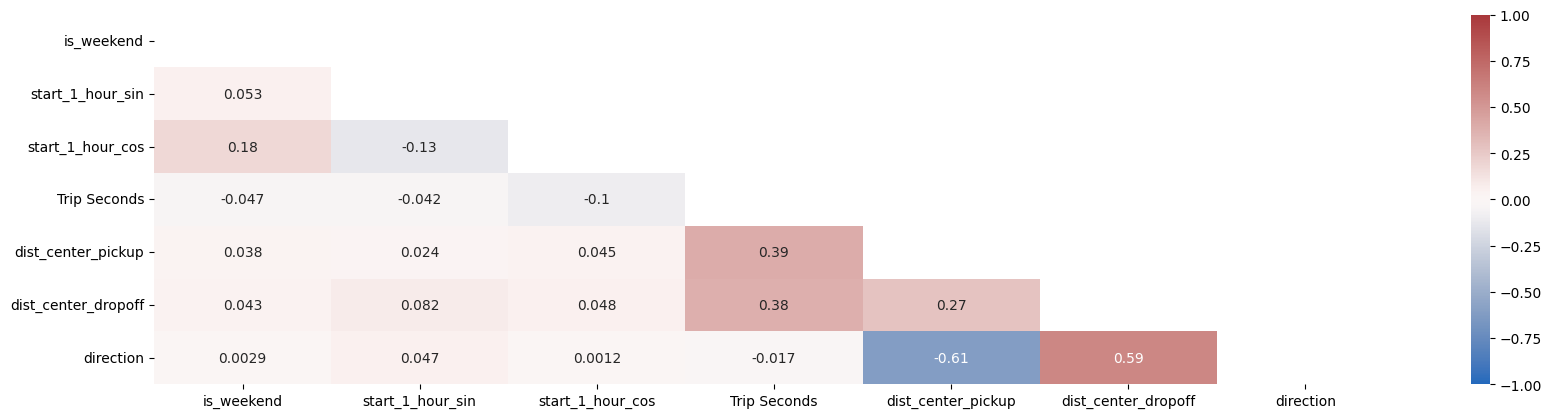

In [34]:
plt_corr(df_trips_enc_clust_scaled)

A strong correlation between direction and dist_center_pickup and dist_center_dropoff is observable. This is because of the calculation of the feature depending on the two distance features.

Calculate the optimal number of clusters using a Grid Search

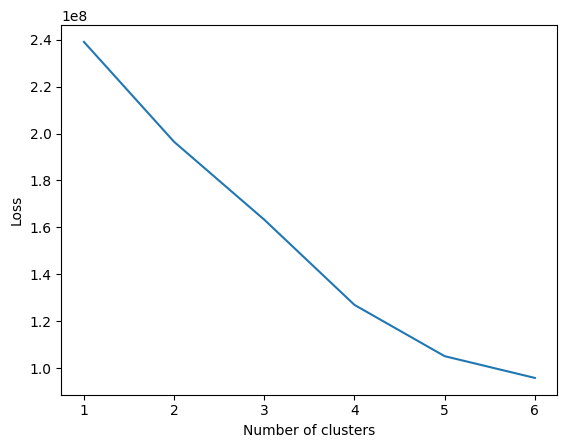

In [35]:
gridSearch(df_trips_enc_clust_scaled, 6)

According to the analysis of the elbow chart, which evaluates the variation in clustering performance across different numbers of clusters, it is determined that the most suitable number of clusters for both the Gaussian Mixture Model and k-means implementations is 4. This choice is grounded in the observation of a significant reduction in within-cluster variance as the number of clusters increases, leveling off around 4 clusters for both algorithms.

### Fitting the models and prediction

Defining the optimal number of clusters for all models

In [36]:
num_cluster = 4

#### Gaussian Mixture Model

In [37]:
model = GaussianMixture(n_components = num_cluster, random_state=42)
fit_and_predict(model, df_trips_enc_clust_scaled, df_trips_clust)

In [38]:
df_trips_clust

is_weekend  start_1_hour  Trip Seconds  dist_center_pickup  \
0                  1            10        1080.0                   2   
2                  1            23         720.0                   5   
3                  1             1         480.0                  12   
5                  0             9         180.0                  49   
6                  1             3         840.0                  10   
...              ...           ...           ...                 ...   
37395431           0            20         900.0                  25   
37395432           0            23         540.0                   7   
37395433           0            12         240.0                   0   
37395434           0            12         360.0                   8   
37395435           0            23         840.0                   3   

          dist_center_dropoff  direction  cluster_GaussianMixture  
0                          26         24                        2  
2                           5          0                        2  
3                          24         12                        2  
5                          40         -9                        0  
6                           3         -7                        2  
...                       ...        ...                      ...  
37395431                   13        -12                        0  
37395432                   25         18                        0  
37395433                    7          7                        0  
37395434                    7         -1                        0  
37395435                   14         11                        0  

[34153067 rows x 7 columns]

In [39]:
feature_distribution(df_trips_clust, f'cluster_{model.__class__.__name__}')

is_weekend           start_1_hour            \
                              mean       std         mean       std   
cluster_GaussianMixture                                               
0                         0.000000  0.000000    14.265631  6.053811   
1                         0.197787  0.398331    11.736980  4.743902   
2                         1.000000  0.000000    11.880668  7.809547   
3                         0.195390  0.396501    14.693786  5.642560   

                        Trip Seconds             dist_center_pickup  \
                                mean         std               mean   
cluster_GaussianMixture                                               
0                         585.088892  397.007981           8.885404   
1                        2249.344652  809.716264           9.197146   
2                         608.907869  401.187468          12.110905   
3                        1901.784847  920.522300          74.369870   

                                   dist_center_dropoff             direction  \
                               std                mean        std       mean   
cluster_GaussianMixture                                                        
0                        10.675324           10.053595  11.410272   1.168191   
1                        10.587124           67.139251  22.711243  57.942105   
2                        11.226415           13.200878  11.960839   1.089973   
3                        11.762991           20.156635  25.426438 -54.213235   

                                   cluster_size first_is_weekend  \
                               std                                 
cluster_GaussianMixture                                            
0                        10.346960     21146759                0   
1                        23.645053      1454979                0   
2                        11.444874      9787409                1   
3                        26.509037      1763920                0   

                        first_start_1_hour first_Trip Seconds  \
                                                                
cluster_GaussianMixture                                         
0                                       19              360.0   
1                                       15             3660.0   
2                                        0              360.0   
3                                       20             3660.0   

                        first_dist_center_pickup first_dist_center_dropoff  \
                                                                             
cluster_GaussianMixture                                                      
0                                              0                         0   
1                                              0                        79   
2                                              4                         4   
3                                             79                         4   

                        first_direction  
                                         
cluster_GaussianMixture                  
0                                     0  
1                                    75  
2                                     0  
3                                   -75

#### KMeans

In [40]:
model = KMeans(n_clusters = num_cluster, n_init=10, init="k-means++", random_state=42)
fit_and_predict(model, df_trips_enc_clust_scaled, df_trips_clust)

In [41]:
df_trips_clust

is_weekend  start_1_hour  Trip Seconds  dist_center_pickup  \
0                  1            10        1080.0                   2   
2                  1            23         720.0                   5   
3                  1             1         480.0                  12   
5                  0             9         180.0                  49   
6                  1             3         840.0                  10   
...              ...           ...           ...                 ...   
37395431           0            20         900.0                  25   
37395432           0            23         540.0                   7   
37395433           0            12         240.0                   0   
37395434           0            12         360.0                   8   
37395435           0            23         840.0                   3   

          dist_center_dropoff  direction  cluster_GaussianMixture  \
0                          26         24                        2   
2                           5          0                        2   
3                          24         12                        2   
5                          40         -9                        0   
6                           3         -7                        2   
...                       ...        ...                      ...   
37395431                   13        -12                        0   
37395432                   25         18                        0   
37395433                    7          7                        0   
37395434                    7         -1                        0   
37395435                   14         11                        0   

          cluster_KMeans  
0                      2  
2                      2  
3                      2  
5                      0  
6                      2  
...                  ...  
37395431               0  
37395432               0  
37395433               0  
37395434               0  
37395435               0  

[34153067 rows x 8 columns]

In [42]:
feature_distribution(df_trips_clust, f'cluster_{model.__class__.__name__}')

is_weekend           start_1_hour           Trip Seconds  \
                     mean       std         mean       std         mean   
cluster_KMeans                                                            
0                0.000000  0.000000    14.310322  6.025219   568.477130   
1                0.217720  0.412696    11.673192  5.215493  1963.716282   
2                1.000000  0.000000    11.862803  7.844999   589.849839   
3                0.211281  0.408217    14.536317  5.786329  1848.374437   

                           dist_center_pickup            dist_center_dropoff  \
                       std               mean        std                mean   
cluster_KMeans                                                                 
0               401.430965           8.340856   9.883148            9.375541   
1               762.943573          10.253518  11.356732           65.430069   
2               393.239455          11.747331  10.773823           12.738733   
3               865.742611          68.649293  16.248486           18.188647   

                           direction            cluster_size first_is_weekend  \
                      std       mean        std                                 
cluster_KMeans                                                                  
0               10.479193   1.034685   8.697524     20585838                0   
1               17.288926  55.176551  19.744751      1849676                0   
2               11.375669   0.991402   9.778988      9561619                1   
3               22.778863 -50.460646  25.148682      2155934                0   

               first_start_1_hour first_Trip Seconds first_dist_center_pickup  \
                                                                                
cluster_KMeans                                                                  
0                              19              360.0                        0   
1                               6             3660.0                        4   
2                               0              360.0                        4   
3                              20             3660.0                       79   

               first_dist_center_dropoff first_direction  
                                                          
cluster_KMeans                                            
0                                      0               0  
1                                     79              75  
2                                      4               0  
3                                      4             -75

#### Evaluation

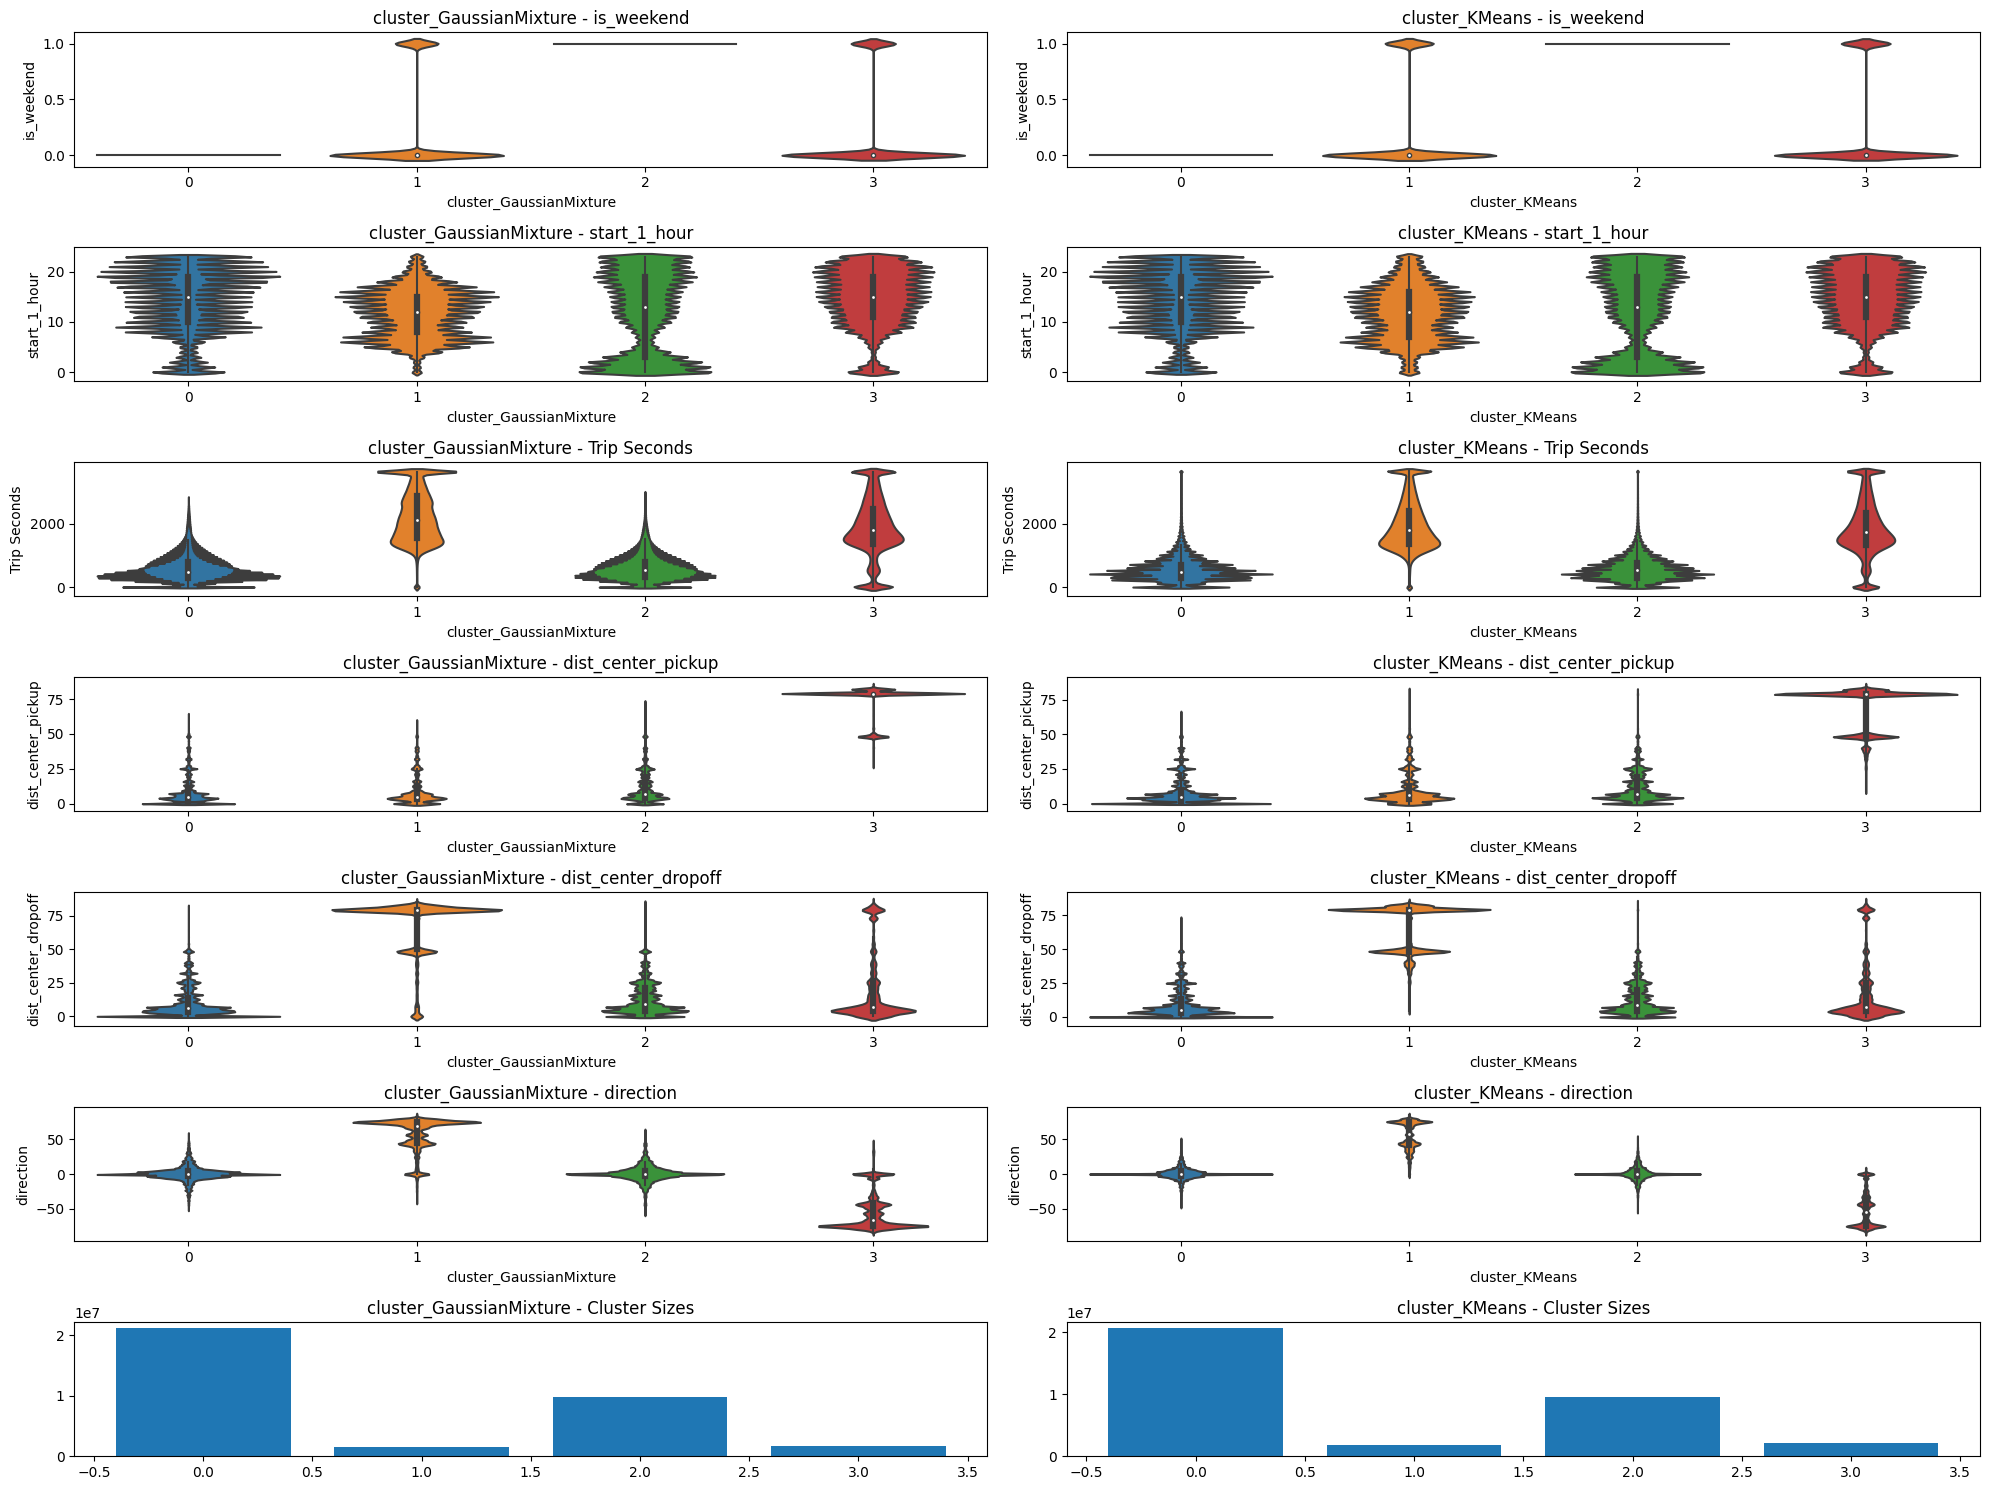

In [43]:
plt_violins(df_trips_clust)

### Analyzing Trip Clusters

Let's dive into the world of trip clusters, where we use two methods – Gaussian Mixture Model (GMM) and K-Means – to group similar travel patterns. Here's what we found:

**Using Gaussian Mixture Model (GMM)**

- Cluster 0 (City trips during the week) is the biggest group, with around 21 million trips. These are city trips that usually happen on weekends. They start and end near the city center and last for about 10 minutes on average. They're different from the other clusters because they only include trips taken on weekdays.

- Cluster 1 (Long rides into the city) has around 1.5 million trips. These are long rides into the city. They start close to the city center, and it takes them around 40 minutes on average to get there. These riders really like long trips. They are similar to Cluster 3.

- Cluster 2 (City trips during the weekend) is the second biggest group, with around 9.8 million trips. These are also city trips on weekends, just like Cluster 0. They're similar in terms of where they start and end and how long they last. But these trips only happen on weekends.

- Cluster 3 includes about 1.8 million trips. These are long rides out of the city. They start far away from the city center and usually last around 30 minutes. The riders in this group prefer going out of the city. They are quite similar to Cluster 1.

**Using K-Means Algorithm**

- Cluster 0 (City trips during the week) in K-Means is pretty much like Cluster 0 in GMM. It's the largest group with about 20.5 million trips. The story remains the same: city trips, starting and ending near the city center, and lasting around 10 minutes on average. Only difference is, these trips happen on weekdays.

- Cluster 1 (Long rides into the city) under K-Means has about 1.8 million trips. These are also long rides into the city, starting near the center and lasting about 40 minutes on average. They're similar to Cluster 3 in GMM.

- Cluster 2 (City trips during the weekend) here mirrors the weekend city trips of Cluster 0 in GMM. Around 9.6 million trips belong to this group, with the same characteristics of starting and ending near the city center and lasting around 10 minutes. But remember, these trips happen only on weekends.

- Cluster 3 (Long rides out of the city) under K-Means includes around 2.2 million trips. These are like the long rides out of the city in GMM's Cluster 3. They start far from the city center and usually last around 30 minutes. The riders prefer going outside the city. Just like in GMM, they are quite similar to Cluster 1.

**Comparing the Results**

Both GMM and K-Means show similar findings. There are some small differences in the number of trips in each group, but the overall patterns are the same. One thing is clear: we can easily tell the difference between trips taken on weekends and weekdays, as well as between short and long rides. These clustering methods give us consistent insights, making our analysis more reliable.

### Trip/Customer clustering

Clustering based on customer specific features. The feature selected for the following analyses are based on the customer behavior - especially their payment behavior.

In [44]:
df_trips

ts_start_1_hour  start_month  start_weekday  start_weekday_sin  \
0        2014-05-17 10:00:00          5.0              5          -0.974928   
2        2014-05-03 23:00:00          5.0              5          -0.974928   
3        2014-05-17 01:00:00          5.0              5          -0.974928   
5        2014-05-14 09:00:00          5.0              2           0.974928   
6        2014-05-04 03:00:00          5.0              6          -0.781831   
...                      ...          ...            ...                ...   
37395431 2014-04-03 20:00:00          4.0              3           0.433884   
37395432 2014-05-13 23:00:00          5.0              1           0.781831   
37395433 2014-05-14 12:00:00          5.0              2           0.974928   
37395434 2014-05-14 12:00:00          5.0              2           0.974928   
37395435 2014-05-13 23:00:00          5.0              1           0.781831   

          start_weekday_cos  start_1_hour  start_1_hour_sin  start_1_hour_cos  \
0                 -0.222521            10      5.000000e-01         -0.866025   
2                 -0.222521            23     -2.588190e-01          0.965926   
3                 -0.222521             1      2.588190e-01          0.965926   
5                 -0.222521             9      7.071068e-01         -0.707107   
6                  0.623490             3      7.071068e-01          0.707107   
...                     ...           ...               ...               ...   
37395431          -0.900969            20     -8.660254e-01          0.500000   
37395432           0.623490            23     -2.588190e-01          0.965926   
37395433          -0.222521            12      1.224647e-16         -1.000000   
37395434          -0.222521            12      1.224647e-16         -1.000000   
37395435           0.623490            23     -2.588190e-01          0.965926   

          Trip Seconds  Trip Total     pickup_hex_9    dropoff_hex_9  \
0               1080.0       18.95  892664c1acfffff  892664c1617ffff   
2                720.0       11.45  892664c1e4fffff  892664c1e33ffff   
3                480.0       11.85  892664c114fffff  892664c163bffff   
5                180.0        5.05  892664d8ccfffff  892664d88bbffff   
6                840.0        9.85  892664c13afffff  892664c1a07ffff   
...                ...         ...              ...              ...   
37395431         900.0       11.25  892664c1607ffff  892664cac3bffff   
37395432         540.0       15.40  892664c1ecfffff  892664c1607ffff   
37395433         240.0        9.75  892664c1a8bffff  892664cad77ffff   
37395434         360.0        5.05  892664c1ed7ffff  892664c1e8fffff   
37395435         840.0       13.70  892664c1e2fffff  892664c13cfffff   

          Payment Type_Cash  Payment Type_Credit Card  dist_center_pickup  \
0                       1.0                       0.0                   2   
2                       0.0                       1.0                   5   
3                       0.0                       1.0                  12   
5                       1.0                       0.0                  49   
6                       1.0                       0.0                  10   
...                     ...                       ...                 ...   
37395431                1.0                       0.0                  25   
37395432                0.0                       1.0                   7   
37395433                0.0                       1.0                   0   
37395434                1.0                       0.0                   8   
37395435                0.0                       1.0                   3   

          dist_center_dropoff  direction  is_weekend  
0                          26         24           1  
2                           5          0           1  
3                          24         12           1  
5                          40         -9           0  
6                         

In [45]:
df_trips.columns

Index(['ts_start_1_hour', 'start_month', 'start_weekday', 'start_weekday_sin',
       'start_weekday_cos', 'start_1_hour', 'start_1_hour_sin',
       'start_1_hour_cos', 'Trip Seconds', 'Trip Total', 'pickup_hex_9',
       'dropoff_hex_9', 'Payment Type_Cash', 'Payment Type_Credit Card',
       'dist_center_pickup', 'dist_center_dropoff', 'direction', 'is_weekend'],
      dtype='object')

Feature selection

In [46]:
# Clustering features
trips_customer_clust_feat     = ['is_weekend',  'start_1_hour', 'Trip Total', 'Payment Type_Credit Card']
# Encoded features
trips_customer_enc_clust_feat = ['is_weekend',  'start_1_hour_sin', 'Trip Total', 'Payment Type_Credit Card']

df_trips_customer_clust = df_trips[trips_customer_clust_feat]
df_trips_customer_enc_clust = df_trips[trips_customer_enc_clust_feat]

Scale encoded dataframe

In [47]:
df_trips_customer_enc_clust_scaled = scale_df(df_trips_customer_enc_clust)

Plot correlation matrix to check for depended features

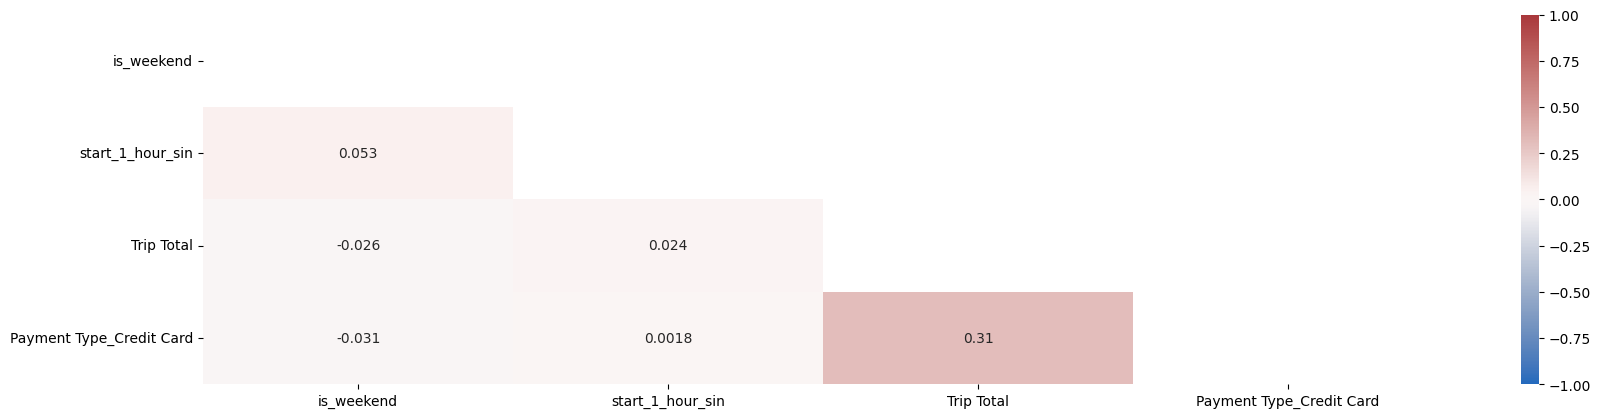

In [48]:
plt_corr(df_trips_customer_enc_clust_scaled)

The correlation matrix highlights a direct link between customer payments and credit card usage, indicating that higher payments correspond to increased credit card activity.

Calculate the optimal number of clusters using a Grid Search

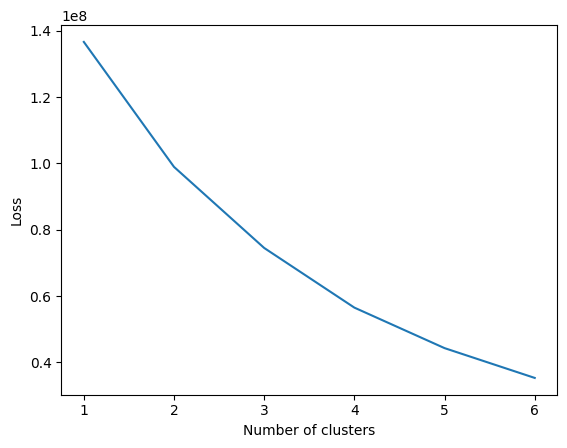

In [49]:
gridSearch(df_trips_customer_enc_clust_scaled, 6)

According to the elbow chart, the optimal number of clusters is 2.

### Fitting the models and prediction

Defining the optimal number of clusters for all models

In [50]:
num_cluster = 2

#### Gaussian Mixture Model

In [51]:
model = GaussianMixture(n_components = num_cluster, random_state=42)
fit_and_predict(model, df_trips_customer_enc_clust_scaled, df_trips_customer_clust)

In [52]:
df_trips_customer_clust

is_weekend  start_1_hour  Trip Total  Payment Type_Credit Card  \
0                  1            10       18.95                       0.0   
2                  1            23       11.45                       1.0   
3                  1             1       11.85                       1.0   
5                  0             9        5.05                       0.0   
6                  1             3        9.85                       0.0   
...              ...           ...         ...                       ...   
37395431           0            20       11.25                       0.0   
37395432           0            23       15.40                       1.0   
37395433           0            12        9.75                       1.0   
37395434           0            12        5.05                       0.0   
37395435           0            23       13.70                       1.0   

          cluster_GaussianMixture  
0                               0  
2                               1  
3                               1  
5                               0  
6                               0  
...                           ...  
37395431                        0  
37395432                        1  
37395433                        1  
37395434                        0  
37395435                        1  

[34153067 rows x 5 columns]

In [53]:
feature_distribution(df_trips_customer_clust, f'cluster_{model.__class__.__name__}')

is_weekend           start_1_hour            \
                              mean       std         mean       std   
cluster_GaussianMixture                                               
0                         0.314968  0.464503    13.486855  6.637276   
1                         0.284228  0.451046    13.517029  6.646596   

                        Trip Total            Payment Type_Credit Card       \
                              mean        std                     mean  std   
cluster_GaussianMixture                                                       
0                        10.600258   8.428695                      0.0  0.0   
1                        17.916032  13.625319                      1.0  0.0   

                        cluster_size first_is_weekend first_start_1_hour  \
                                                                           
cluster_GaussianMixture                                                    
0                           23180477                0                 19   
1                           10972590                0                 19   

                        first_Trip Total first_Payment Type_Credit Card  
                                                                         
cluster_GaussianMixture                                                  
0                                   3.25                            0.0  
1                                   8.65                            1.0

#### KMeans

In [54]:
model = KMeans(n_clusters = num_cluster, n_init=10, init="k-means++", random_state=42)
fit_and_predict(model, df_trips_customer_enc_clust_scaled, df_trips_customer_clust)

In [55]:
df_trips_customer_clust

is_weekend  start_1_hour  Trip Total  Payment Type_Credit Card  \
0                  1            10       18.95                       0.0   
2                  1            23       11.45                       1.0   
3                  1             1       11.85                       1.0   
5                  0             9        5.05                       0.0   
6                  1             3        9.85                       0.0   
...              ...           ...         ...                       ...   
37395431           0            20       11.25                       0.0   
37395432           0            23       15.40                       1.0   
37395433           0            12        9.75                       1.0   
37395434           0            12        5.05                       0.0   
37395435           0            23       13.70                       1.0   

          cluster_GaussianMixture  cluster_KMeans  
0                               0               0  
2                               1               1  
3                               1               1  
5                               0               0  
6                               0               0  
...                           ...             ...  
37395431                        0               0  
37395432                        1               1  
37395433                        1               1  
37395434                        0               0  
37395435                        1               1  

[34153067 rows x 6 columns]

In [56]:
feature_distribution(df_trips_customer_clust, f'cluster_{model.__class__.__name__}')

is_weekend           start_1_hour           Trip Total  \
                     mean       std         mean       std       mean   
cluster_KMeans                                                          
0                0.315376  0.464665    13.489402  6.640132  10.364301   
1                0.283686  0.450786    13.511426  6.640584  18.334568   

                          Payment Type_Credit Card           cluster_size  \
                      std                     mean       std                
cluster_KMeans                                                              
0                7.693286                  0.00000  0.000000     23070421   
1               14.221310                  0.99007  0.099156     11082646   

               first_is_weekend first_start_1_hour first_Trip Total  \
                                                                      
cluster_KMeans                                                        
0                             0                 19             3.25   
1                             0                 19             8.65   

               first_Payment Type_Credit Card  
                                               
cluster_KMeans                                 
0                                         0.0  
1                                         1.0

#### Evaluation

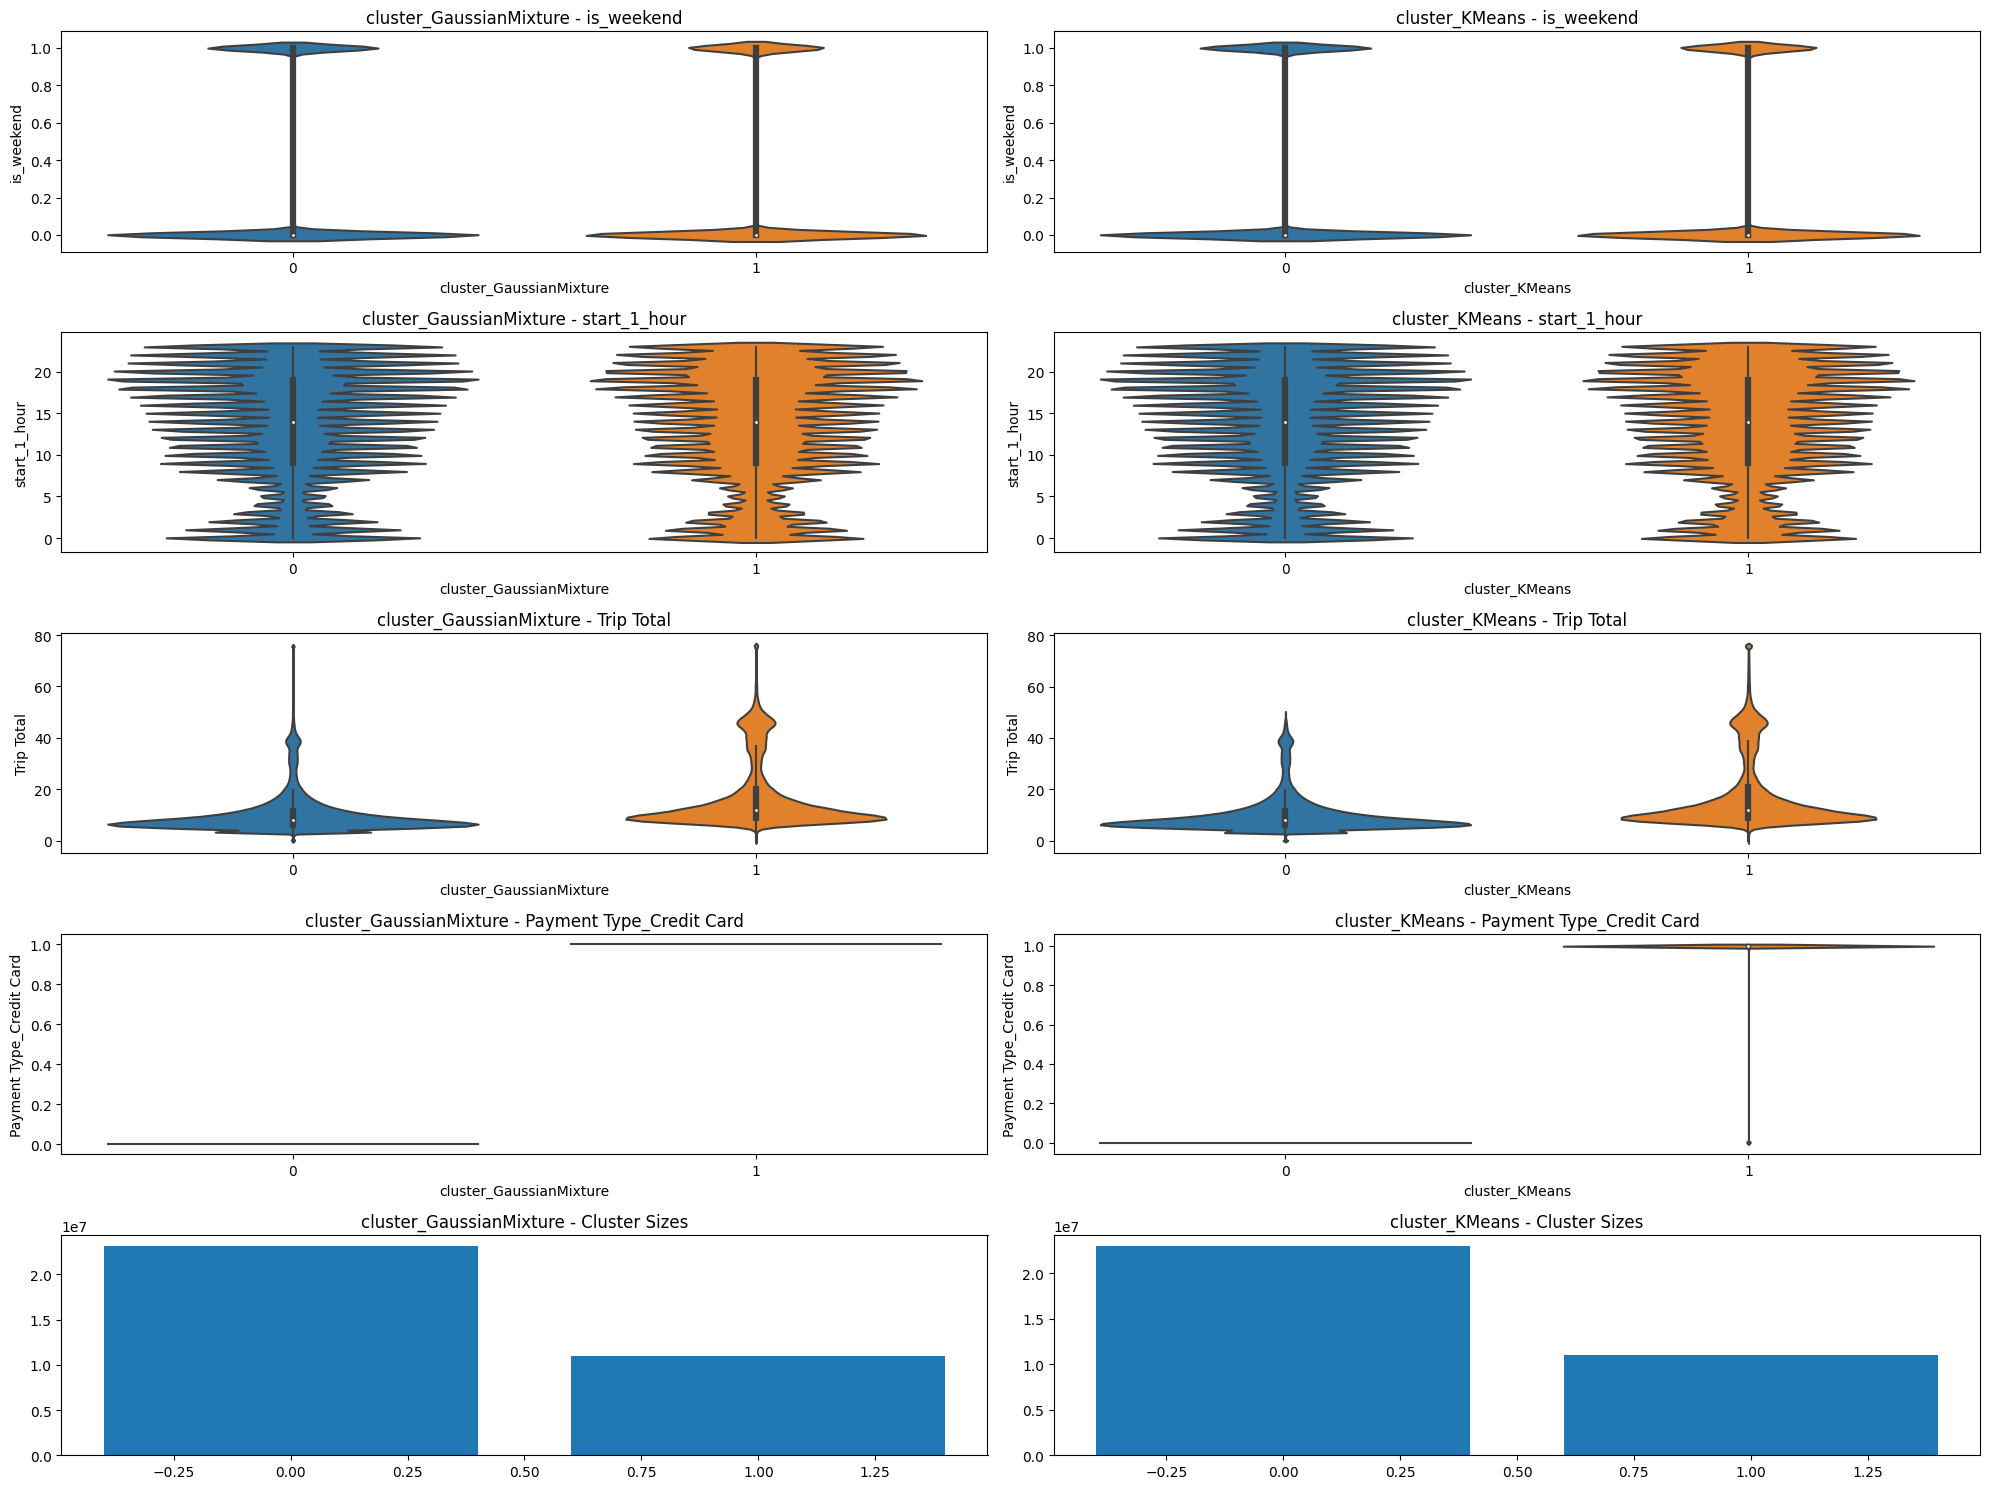

In [57]:
plt_violins(df_trips_customer_clust)

### Trip/Customer Clustering Analysis

**Gaussian Mixture Model (GMM)**

Cluster 0 (Cheaper rides, no card payment), the most substantial cluster with a size of 23,180,477, is characterized by economically-priced rides facilitated without card payments. These rides predominantly commence around 2 pm. Notably, the mean trip total expenditure stands at $10.60.

Cluster 1 (More expensive rides, card payment), encompassing 10,972,590 instances, constitutes rides of a relatively higher economic order, chiefly transacted through card payments. It's noteworthy that this cluster's size is half that of Cluster 0. The temporal onset aligns with the broader pattern, initiating around 2 pm. Importantly, the rides within this cluster exhibit an average total expenditure 1.8 times greater than those within Cluster 0, amounting to $17.91.

**K-Means Algorithm**

Cluster 0 (Cheaper rides, no card payment) in the K-Means paradigm reflects the economical rides not involving card payments, mirroring the GMM's Cluster 0. This constitutes the largest cluster, encapsulating 23,070,421 instances. The temporal initiation remains coherent at approximately 2 pm. The mean total trip cost averages at $10.36.

Cluster 1 (More expensive rides, card payment) in K-Means, comprised of 11,082,646 instances, mirrors GMM's Cluster 1. These journeys involve comparatively pricier rides, facilitated through card transactions. With a size half that of Cluster 0, this cluster also exhibits a similar temporal initiation, aligning with the general trend around 2 pm. Critically, the average total expenditure for rides in this cluster is 1.8 times higher than those within Cluster 0, amounting to $18.33.

**Comparative Insights**

A comparison between the clustering methodologies reveals striking congruence in the results. Both GMM and K-Means yield akin clustering patterns, underscoring the robustness of the obtained insights. While minor discrepancies in cluster sizes persist, the overarching patterns remain consistent.

Importantly, GMM effectively distinguishes the payment modalities, segregating rides based on payment method characteristics. Furthermore, the analyses indicate that the day of the week does not significantly influence the identified clustering patterns. This unified depiction underscores the reliability and stability of the clustering approaches employed in this investigation.

## Weather-based clustering

In this section, the trip data is enhanced by weather features as precipitation and temperature to gain more insights of the taxi usage.

### Weather clustering

Clustering based on same features as trip clustering enhanced by weather feature

In [58]:
df_trips

ts_start_1_hour  start_month  start_weekday  start_weekday_sin  \
0        2014-05-17 10:00:00          5.0              5          -0.974928   
2        2014-05-03 23:00:00          5.0              5          -0.974928   
3        2014-05-17 01:00:00          5.0              5          -0.974928   
5        2014-05-14 09:00:00          5.0              2           0.974928   
6        2014-05-04 03:00:00          5.0              6          -0.781831   
...                      ...          ...            ...                ...   
37395431 2014-04-03 20:00:00          4.0              3           0.433884   
37395432 2014-05-13 23:00:00          5.0              1           0.781831   
37395433 2014-05-14 12:00:00          5.0              2           0.974928   
37395434 2014-05-14 12:00:00          5.0              2           0.974928   
37395435 2014-05-13 23:00:00          5.0              1           0.781831   

          start_weekday_cos  start_1_hour  start_1_hour_sin  start_1_hour_cos  \
0                 -0.222521            10      5.000000e-01         -0.866025   
2                 -0.222521            23     -2.588190e-01          0.965926   
3                 -0.222521             1      2.588190e-01          0.965926   
5                 -0.222521             9      7.071068e-01         -0.707107   
6                  0.623490             3      7.071068e-01          0.707107   
...                     ...           ...               ...               ...   
37395431          -0.900969            20     -8.660254e-01          0.500000   
37395432           0.623490            23     -2.588190e-01          0.965926   
37395433          -0.222521            12      1.224647e-16         -1.000000   
37395434          -0.222521            12      1.224647e-16         -1.000000   
37395435           0.623490            23     -2.588190e-01          0.965926   

          Trip Seconds  Trip Total     pickup_hex_9    dropoff_hex_9  \
0               1080.0       18.95  892664c1acfffff  892664c1617ffff   
2                720.0       11.45  892664c1e4fffff  892664c1e33ffff   
3                480.0       11.85  892664c114fffff  892664c163bffff   
5                180.0        5.05  892664d8ccfffff  892664d88bbffff   
6                840.0        9.85  892664c13afffff  892664c1a07ffff   
...                ...         ...              ...              ...   
37395431         900.0       11.25  892664c1607ffff  892664cac3bffff   
37395432         540.0       15.40  892664c1ecfffff  892664c1607ffff   
37395433         240.0        9.75  892664c1a8bffff  892664cad77ffff   
37395434         360.0        5.05  892664c1ed7ffff  892664c1e8fffff   
37395435         840.0       13.70  892664c1e2fffff  892664c13cfffff   

          Payment Type_Cash  Payment Type_Credit Card  dist_center_pickup  \
0                       1.0                       0.0                   2   
2                       0.0                       1.0                   5   
3                       0.0                       1.0                  12   
5                       1.0                       0.0                  49   
6                       1.0                       0.0                  10   
...                     ...                       ...                 ...   
37395431                1.0                       0.0                  25   
37395432                0.0                       1.0                   7   
37395433                0.0                       1.0                   0   
37395434                1.0                       0.0                   8   
37395435                0.0                       1.0                   3   

          dist_center_dropoff  direction  is_weekend  
0                          26         24           1  
2                           5          0           1  
3                          24         12           1  
5                          40         -9           0  
6                         

In [59]:
df_trips.columns

Index(['ts_start_1_hour', 'start_month', 'start_weekday', 'start_weekday_sin',
       'start_weekday_cos', 'start_1_hour', 'start_1_hour_sin',
       'start_1_hour_cos', 'Trip Seconds', 'Trip Total', 'pickup_hex_9',
       'dropoff_hex_9', 'Payment Type_Cash', 'Payment Type_Credit Card',
       'dist_center_pickup', 'dist_center_dropoff', 'direction', 'is_weekend'],
      dtype='object')

Feature selection

In [60]:
# Clustering features
trips_clust_feat     = ['ts_start_1_hour', 'is_weekend',  'start_1_hour', 'Trip Seconds']
# Encoded features
trips_enc_clust_feat = ['ts_start_1_hour', 'is_weekend',  'start_1_hour_sin', 'start_1_hour_cos', 'Trip Seconds']

df_trips_clust = df_trips[trips_clust_feat]
df_trips_enc_clust = df_trips[trips_enc_clust_feat]

In [61]:
df_weather

Temperature  Precip.  cloud
datetime                                        
2014-01-01 00:00:00        -10.0      0.0    3.0
2014-01-01 01:00:00         -8.9      0.0    3.0
2014-01-01 02:00:00         -8.3      0.0    3.0
2014-01-01 03:00:00         -7.8      0.0    3.0
2014-01-01 04:00:00         -7.2      0.0    3.0
...                          ...      ...    ...
2014-12-31 19:00:00         -7.2      0.0    0.0
2014-12-31 20:00:00         -7.2      0.0    0.0
2014-12-31 21:00:00         -6.7      0.0    0.0
2014-12-31 22:00:00         -6.7      0.0    0.0
2014-12-31 23:00:00         -6.7      0.0    0.0

[8760 rows x 3 columns]

Joining trips and weather data

In [62]:
df_weather_clust = df_trips_clust.merge(df_weather, left_on='ts_start_1_hour', right_on='datetime', how='left')
df_weather_enc_clust = df_trips_enc_clust.merge(df_weather, left_on='ts_start_1_hour', right_on='datetime', how='left')

df_weather_clust.drop(columns=['ts_start_1_hour'], inplace=True)
df_weather_enc_clust.drop(columns=['ts_start_1_hour'], inplace=True)

In [63]:
df_weather_clust

is_weekend  start_1_hour  Trip Seconds  Temperature  Precip.  cloud
0                  1            10        1080.0         12.2      0.0    2.0
1                  1            23         720.0         16.7      0.0    3.0
2                  1             1         480.0          6.7      0.0    3.0
3                  0             9         180.0         13.3      0.0    3.0
4                  1             3         840.0         13.3      0.0    1.0
...              ...           ...           ...          ...      ...    ...
34153062           0            20         900.0          3.9      0.0    0.0
34153063           0            23         540.0         12.8      0.0    3.0
34153064           0            12         240.0         13.3      0.0    3.0
34153065           0            12         360.0         13.3      0.0    3.0
34153066           0            23         840.0         12.8      0.0    3.0

[34153067 rows x 6 columns]

Scale encoded dataframe

In [64]:
df_weather_enc_clust_scaled = scale_df(df_weather_enc_clust)

Plot correlation matrix to check for depended features

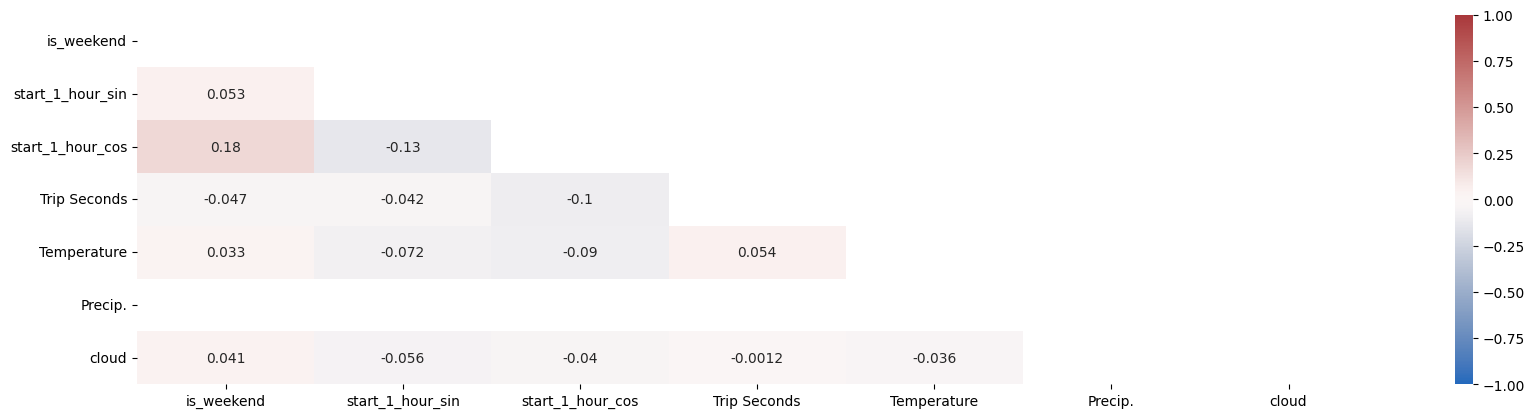

In [65]:
plt_corr(df_weather_enc_clust_scaled)

The correlation matrix show no significant dependencies between features besides a weak correlation between is_weekend and start_hour.

Calculate the optimal number of clusters using a Grid Search

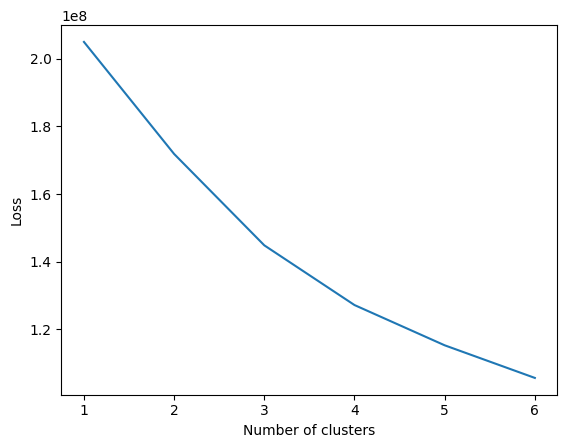

In [66]:
gridSearch(df_weather_enc_clust_scaled, 6)

According to the elbow chart, the optimal number of clusters is 4.

### Fitting the models and prediction

Defining the optimal number of clusters for all models

In [67]:
num_cluster = 4

#### Gaussian Mixture Model

In [68]:
model = GaussianMixture(n_components = num_cluster, random_state=42)
fit_and_predict(model, df_weather_enc_clust_scaled, df_weather_clust)

In [69]:
df_weather_clust

is_weekend  start_1_hour  Trip Seconds  Temperature  Precip.  cloud  \
0                  1            10        1080.0         12.2      0.0    2.0   
1                  1            23         720.0         16.7      0.0    3.0   
2                  1             1         480.0          6.7      0.0    3.0   
3                  0             9         180.0         13.3      0.0    3.0   
4                  1             3         840.0         13.3      0.0    1.0   
...              ...           ...           ...          ...      ...    ...   
34153062           0            20         900.0          3.9      0.0    0.0   
34153063           0            23         540.0         12.8      0.0    3.0   
34153064           0            12         240.0         13.3      0.0    3.0   
34153065           0            12         360.0         13.3      0.0    3.0   
34153066           0            23         840.0         12.8      0.0    3.0   

          cluster_GaussianMixture  
0                               1  
1                               1  
2                               1  
3                               2  
4                               1  
...                           ...  
34153062                        0  
34153063                        0  
34153064                        2  
34153065                        2  
34153066                        0  

[34153067 rows x 7 columns]

In [70]:
feature_distribution(df_weather_clust, f'cluster_{model.__class__.__name__}')

is_weekend           start_1_hour            \
                              mean       std         mean       std   
cluster_GaussianMixture                                               
0                         0.000000  0.000000    17.217089  6.834668   
1                         1.000000  0.000000    11.985977  7.707448   
2                         0.000000  0.000000    11.414040  3.295339   
3                         0.164692  0.370903    15.530621  3.816300   

                        Trip Seconds             Temperature             \
                                mean         std        mean        std   
cluster_GaussianMixture                                                   
0                         633.511320  438.215374   10.483665  11.846872   
1                         677.175731  508.430057   11.897143  11.554740   
2                         816.875969  750.729416   11.493652  12.755137   
3                        3659.999787    0.016284   14.375593  11.834705   

                        Precip.          cloud           cluster_size  \
                           mean  std      mean       std                
cluster_GaussianMixture                                                 
0                           0.0  0.0  1.564600  1.271186     11096073   
1                           0.0  0.0  1.676979  1.173388     10388167   
2                           0.0  0.0  1.571634  1.227062     12476522   
3                           0.0  0.0  1.554239  1.201080       192305   

                        first_is_weekend first_start_1_hour  \
                                                              
cluster_GaussianMixture                                       
0                                      0                 19   
1                                      1                  0   
2                                      0                  9   
3                                      0                 16   

                        first_Trip Seconds first_Temperature first_Precip.  \
                                                                             
cluster_GaussianMixture                                                      
0                                    360.0              16.7           0.0   
1                                    360.0              22.8           0.0   
2                                    360.0              23.3           0.0   
3                                   3660.0              22.8           0.0   

                        first_cloud  
                                     
cluster_GaussianMixture              
0                               3.0  
1                               3.0  
2                               0.0  
3                               0.0

#### KMeans

In [71]:
model = KMeans(n_clusters = num_cluster, n_init=10, init="k-means++", random_state=42)
fit_and_predict(model, df_weather_enc_clust_scaled, df_weather_clust)

In [72]:
df_weather_clust

is_weekend  start_1_hour  Trip Seconds  Temperature  Precip.  cloud  \
0                  1            10        1080.0         12.2      0.0    2.0   
1                  1            23         720.0         16.7      0.0    3.0   
2                  1             1         480.0          6.7      0.0    3.0   
3                  0             9         180.0         13.3      0.0    3.0   
4                  1             3         840.0         13.3      0.0    1.0   
...              ...           ...           ...          ...      ...    ...   
34153062           0            20         900.0          3.9      0.0    0.0   
34153063           0            23         540.0         12.8      0.0    3.0   
34153064           0            12         240.0         13.3      0.0    3.0   
34153065           0            12         360.0         13.3      0.0    3.0   
34153066           0            23         840.0         12.8      0.0    3.0   

          cluster_GaussianMixture  cluster_KMeans  
0                               1               1  
1                               1               1  
2                               1               1  
3                               2               0  
4                               1               1  
...                           ...             ...  
34153062                        0               2  
34153063                        0               2  
34153064                        2               0  
34153065                        2               0  
34153066                        0               2  

[34153067 rows x 8 columns]

In [73]:
feature_distribution(df_weather_clust, f'cluster_{model.__class__.__name__}')

is_weekend           start_1_hour           Trip Seconds  \
                     mean       std         mean       std         mean   
cluster_KMeans                                                            
0                0.000000  0.000000    10.027036  2.770484   566.916469   
1                1.000000  0.000000    11.885588  7.809212   612.109355   
2                0.000000  0.000000    17.125706  6.180297   582.804624   
3                0.160835  0.367379    14.037608  4.299100  2394.508468   

                           Temperature            Precip.          cloud  \
                       std        mean        std    mean  std      mean   
cluster_KMeans                                                             
0               373.547641   10.722800  12.799734     0.0  0.0  1.538283   
1               389.724834   11.732733  11.538592     0.0  0.0  1.675179   
2               365.621665   10.770948  12.051908     0.0  0.0  1.586113   
3               648.969866   14.113339  11.729409     0.0  0.0  1.606603   

                         cluster_size first_is_weekend first_start_1_hour  \
                     std                                                    
cluster_KMeans                                                              
0               1.250202      8912624                0                  9   
1               1.177119      9984469                1                  0   
2               1.252613     12549043                0                 19   
3               1.190148      2706931                0                 15   

               first_Trip Seconds first_Temperature first_Precip. first_cloud  
                                                                               
cluster_KMeans                                                                 
0                           360.0              23.3           0.0         0.0  
1                           360.0              22.8           0.0         3.0  
2                           360.0              22.8           0.0         3.0  
3                          3660.0              22.8           0.0         3.0

#### Evaluation

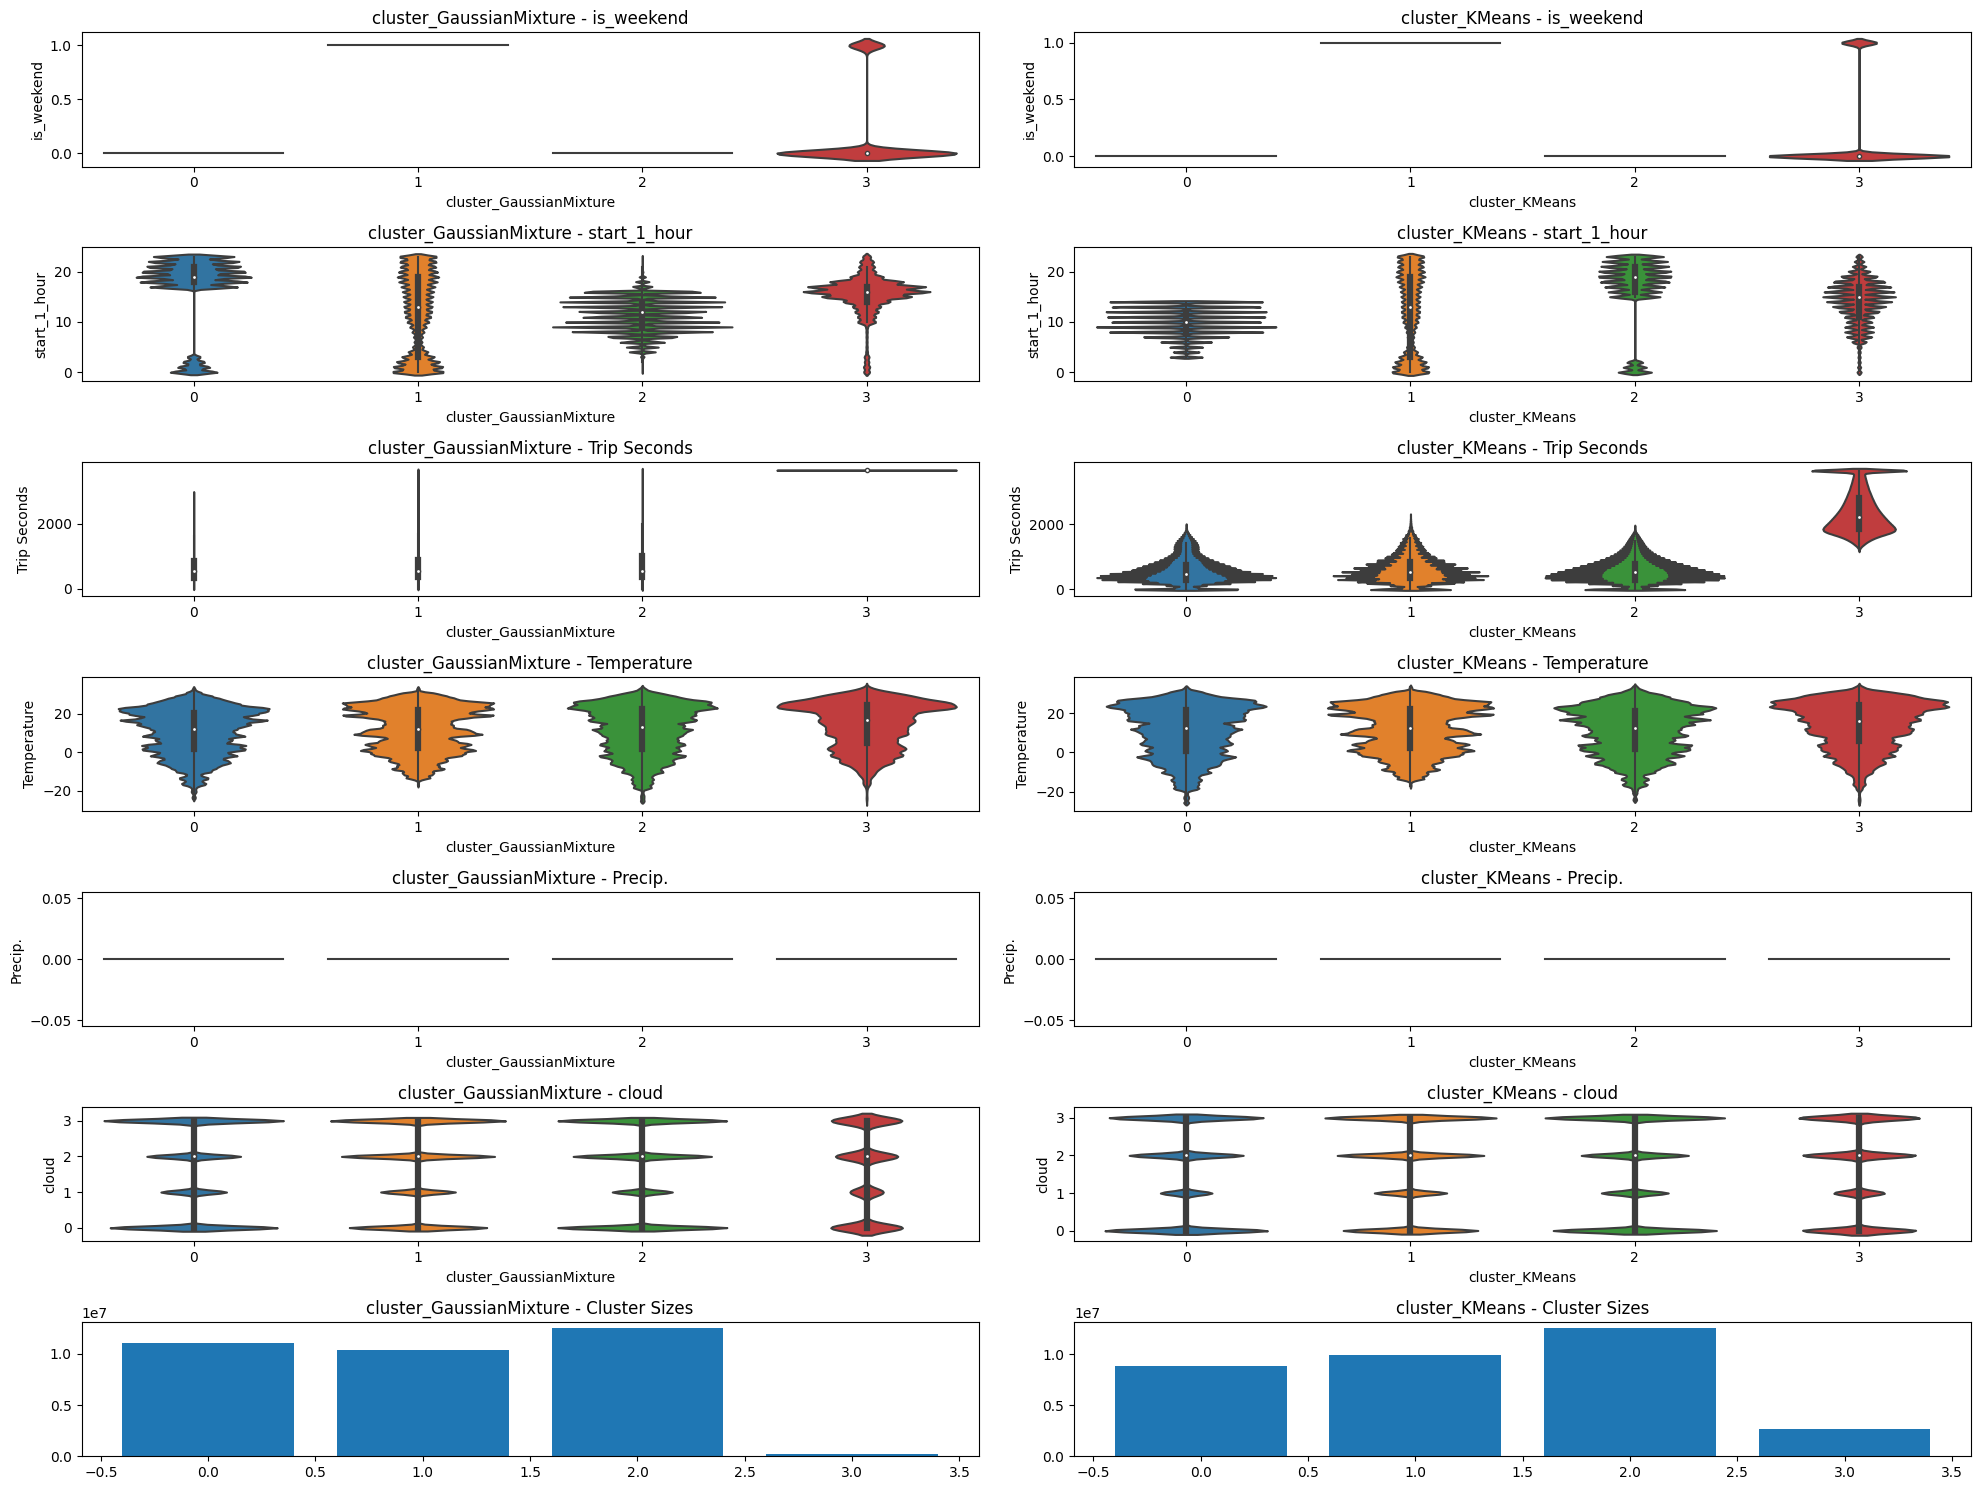

In [74]:
plt_violins(df_weather_clust)

### Weather-Based Clustering Insights

We wanted to understand how weather affects rides, so we used two methods – Gaussian Mixture Model (GMM) and K-Means – to group rides based on weather patterns. Here's what we found:

**Gaussian Mixture Model (GMM)**

Cluster 0 has around 11 million rides. These rides happen on weekdays, mostly at night, and the weather during these rides is about 10.5°C on average.

Cluster 1 includes about 10 million rides. These are weekend rides, and the weather is around 11.9°C.

Cluster 2 is the biggest group with around 12 million rides. These rides take place on weekdays, during the day, with the weather at an average of 11.5°C.

Cluster 3 is the smallest, with about 192,000 rides. These are mostly weekday rides, and they tend to be really long, lasting more than an hour.

**K-Means Algorithm**

Cluster 0 in K-Means has about 8.9 million rides. They happen on weekdays, mostly during the day, and the weather is less cloudy, averaging around 10.7°C.

Cluster 1 includes around 10 million rides. These are weekend rides, and the weather is about 11.7°C.

Cluster 2 is the largest with around 12.5 million rides. These are weekday rides, mostly at night, with the weather averaging around 10.8°C.

Cluster 3 has about 2.7 million rides. Like in GMM's Cluster 3, these are mostly weekday rides. The weather is a bit warmer at around 14.1°C on average. These rides are also quite long, but just a bit less than an hour.

**Comparative Insights**

Comparing GMM and K-Means, we see similar patterns. Both methods give us comparable results, showing that the weather doesn't play a big role in how rides are grouped. There are some differences in the sizes of certain groups, but overall, the weather doesn't seem to be the main factor influencing ride patterns. This consistency in findings tells us that the way we're grouping rides is reliable and can be trusted.

## Hexagon-based clustering

The following analyses focus on the spatial features and insights that can be gained from the trip data. The following patterns are from interest:
- Hexagon demand clustering
- Hexagon demand clustering separated by weekend/weekday
- Hexagon hotspot clustering

### Hexagon demand clustering

Clustering based the demand per hexagon. The selected method involves consolidating the absolute demand for each starting hexagon and hour across the entire timeframe. This process enables the identification of locations displaying analogous demand patterns, which subsequently guide the creation of high-demand hexagonal clusters. Our primary emphasis remains on starting points and hours, with less attention directed towards ending locations. This is due to the fact that an analogous analysis involving ending locations yielded nearly identical outcomes. Moreover, the availability data inherently reflects trip endings as well.

In [75]:
df_trips

ts_start_1_hour  start_month  start_weekday  start_weekday_sin  \
0        2014-05-17 10:00:00          5.0              5          -0.974928   
2        2014-05-03 23:00:00          5.0              5          -0.974928   
3        2014-05-17 01:00:00          5.0              5          -0.974928   
5        2014-05-14 09:00:00          5.0              2           0.974928   
6        2014-05-04 03:00:00          5.0              6          -0.781831   
...                      ...          ...            ...                ...   
37395431 2014-04-03 20:00:00          4.0              3           0.433884   
37395432 2014-05-13 23:00:00          5.0              1           0.781831   
37395433 2014-05-14 12:00:00          5.0              2           0.974928   
37395434 2014-05-14 12:00:00          5.0              2           0.974928   
37395435 2014-05-13 23:00:00          5.0              1           0.781831   

          start_weekday_cos  start_1_hour  start_1_hour_sin  start_1_hour_cos  \
0                 -0.222521            10      5.000000e-01         -0.866025   
2                 -0.222521            23     -2.588190e-01          0.965926   
3                 -0.222521             1      2.588190e-01          0.965926   
5                 -0.222521             9      7.071068e-01         -0.707107   
6                  0.623490             3      7.071068e-01          0.707107   
...                     ...           ...               ...               ...   
37395431          -0.900969            20     -8.660254e-01          0.500000   
37395432           0.623490            23     -2.588190e-01          0.965926   
37395433          -0.222521            12      1.224647e-16         -1.000000   
37395434          -0.222521            12      1.224647e-16         -1.000000   
37395435           0.623490            23     -2.588190e-01          0.965926   

          Trip Seconds  Trip Total     pickup_hex_9    dropoff_hex_9  \
0               1080.0       18.95  892664c1acfffff  892664c1617ffff   
2                720.0       11.45  892664c1e4fffff  892664c1e33ffff   
3                480.0       11.85  892664c114fffff  892664c163bffff   
5                180.0        5.05  892664d8ccfffff  892664d88bbffff   
6                840.0        9.85  892664c13afffff  892664c1a07ffff   
...                ...         ...              ...              ...   
37395431         900.0       11.25  892664c1607ffff  892664cac3bffff   
37395432         540.0       15.40  892664c1ecfffff  892664c1607ffff   
37395433         240.0        9.75  892664c1a8bffff  892664cad77ffff   
37395434         360.0        5.05  892664c1ed7ffff  892664c1e8fffff   
37395435         840.0       13.70  892664c1e2fffff  892664c13cfffff   

          Payment Type_Cash  Payment Type_Credit Card  dist_center_pickup  \
0                       1.0                       0.0                   2   
2                       0.0                       1.0                   5   
3                       0.0                       1.0                  12   
5                       1.0                       0.0                  49   
6                       1.0                       0.0                  10   
...                     ...                       ...                 ...   
37395431                1.0                       0.0                  25   
37395432                0.0                       1.0                   7   
37395433                0.0                       1.0                   0   
37395434                1.0                       0.0                   8   
37395435                0.0                       1.0                   3   

          dist_center_dropoff  direction  is_weekend  
0                          26         24           1  
2                           5          0           1  
3                          24         12           1  
5                          40         -9           0  
6                         

In [76]:
df_trips.columns

Index(['ts_start_1_hour', 'start_month', 'start_weekday', 'start_weekday_sin',
       'start_weekday_cos', 'start_1_hour', 'start_1_hour_sin',
       'start_1_hour_cos', 'Trip Seconds', 'Trip Total', 'pickup_hex_9',
       'dropoff_hex_9', 'Payment Type_Cash', 'Payment Type_Credit Card',
       'dist_center_pickup', 'dist_center_dropoff', 'direction', 'is_weekend'],
      dtype='object')

Feature selection

In [77]:
# Aggregate trips based on start_hour and hexagon ID
df_hex_pickup_clust = df_trips.groupby(by=['start_1_hour', f'pickup_hex_{HEX_RES}']).count()['ts_start_1_hour']

# unstack to retrieve demand in each hour as feature for each hexagon and fill resulting nan values with demand of zero
df_hex_pickup_clust = df_hex_pickup_clust.unstack(0)
df_hex_pickup_clust = df_hex_pickup_clust.fillna(0)

# rename columns
df_hex_pickup_clust.columns = df_hex_pickup_clust.columns.map(str)

df_hex_pickup_clust

start_1_hour        0     1     2     3     4     5     6      7      8  \
pickup_hex_9                                                              
89266419157ffff   6.0   1.0   1.0   8.0   4.0   5.0   3.0   12.0    6.0   
89266419493ffff   6.0   9.0   6.0   9.0   6.0   9.0   6.0    9.0   12.0   
89266419607ffff  11.0  15.0  10.0  23.0  11.0  13.0  23.0   51.0   54.0   
8926641962fffff   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0    0.0   
8926645204fffff   0.0   0.0   0.0   0.0   0.0   0.0   1.0    0.0    0.0   
...               ...   ...   ...   ...   ...   ...   ...    ...    ...   
89275936b77ffff   1.0   0.0   0.0   1.0   0.0   3.0   4.0    0.0    1.0   
89275936bb3ffff   0.0   0.0   0.0   0.0   0.0   4.0  14.0    1.0    1.0   
89275936bc7ffff   6.0   1.0   7.0   0.0   0.0  10.0  43.0   73.0  132.0   
89275936d37ffff   3.0   0.0   2.0   1.0   1.0   0.0   0.0    3.0    3.0   
89275936d53ffff  69.0  99.0  96.0  76.0  61.0  74.0  85.0  181.0   55.0   

start_1_hour         9  ...    14     15     16    17     18    19    20  \
pickup_hex_9            ...                                                
89266419157ffff   11.0  ...   9.0   13.0    7.0   5.0   10.0   9.0   8.0   
89266419493ffff    9.0  ...  16.0    8.0   10.0  10.0   12.0  14.0   9.0   
89266419607ffff  107.0  ...  58.0   88.0  130.0  29.0   23.0  26.0  22.0   
8926641962fffff    0.0  ...   0.0    0.0    0.0   0.0    0.0   0.0   0.0   
8926645204fffff    0.0  ...   0.0    0.0    0.0   0.0    0.0   0.0   0.0   
...                ...  ...   ...    ...    ...   ...    ...   ...   ...   
89275936b77ffff    0.0  ...   6.0    5.0    2.0   8.0    0.0   0.0   2.0   
89275936bb3ffff    0.0  ...   7.0    3.0    7.0   8.0    7.0   2.0   1.0   
89275936bc7ffff  124.0  ...  46.0  104.0  127.0  94.0  119.0  61.0  24.0   
89275936d37ffff    0.0  ...   0.0    4.0    0.0   0.0    2.0   0.0   0.0   
89275936d53ffff   54.0  ...  45.0   38.0   38.0  45.0   48.0  54.0  42.0   

start_1_hour       21    22    23  
pickup_hex_9                       
89266419157ffff   2.0   4.0   2.0  
89266419493ffff   9.0   5.0   4.0  
89266419607ffff  18.0  22.0   8.0  
8926641962fffff   0.0   0.0   0.0  
8926645204fffff   0.0   0.0   0.0  
...               ...   ...   ...  
89275936b77ffff   3.0   1.0   0.0  
89275936bb3ffff   4.0   3.0   3.0  
89275936bc7ffff   9.0   7.0   9.0  
89275936d37ffff   6.0   1.0   0.0  
89275936d53ffff  45.0  58.0  66.0  

[685 rows x 24 columns]

Scale encoded dataframe

In [78]:
df_hex_pickup_clust_scaled = scale_df(df_hex_pickup_clust)

Calculate the optimal number of clusters using a Grid Search

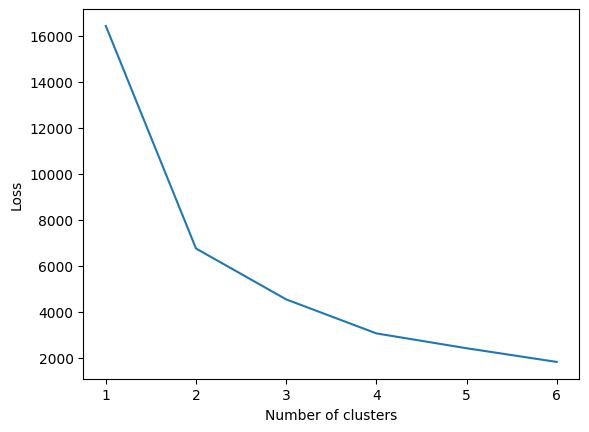

In [79]:
gridSearch(df_hex_pickup_clust_scaled, 6)

According to the elbow chart, the optimal number of clusters is 2. Since the first evaluation has shown that the cluster sizes vary significantly, the larger cluster needs to be seperated as well by calculating 3 clusters.

#### Fitting the models and prediction

Defining the optimal number of clusters for all models

In [80]:
num_cluster = 3

#### Gaussian Mixture Model

In [81]:
model = GaussianMixture(n_components = num_cluster, random_state=42)
fit_and_predict(model, df_hex_pickup_clust_scaled, df_hex_pickup_clust)

In [82]:
df_weather_clust

is_weekend  start_1_hour  Trip Seconds  Temperature  Precip.  cloud  \
0                  1            10        1080.0         12.2      0.0    2.0   
1                  1            23         720.0         16.7      0.0    3.0   
2                  1             1         480.0          6.7      0.0    3.0   
3                  0             9         180.0         13.3      0.0    3.0   
4                  1             3         840.0         13.3      0.0    1.0   
...              ...           ...           ...          ...      ...    ...   
34153062           0            20         900.0          3.9      0.0    0.0   
34153063           0            23         540.0         12.8      0.0    3.0   
34153064           0            12         240.0         13.3      0.0    3.0   
34153065           0            12         360.0         13.3      0.0    3.0   
34153066           0            23         840.0         12.8      0.0    3.0   

          cluster_GaussianMixture  cluster_KMeans  
0                               1               1  
1                               1               1  
2                               1               1  
3                               2               0  
4                               1               1  
...                           ...             ...  
34153062                        0               2  
34153063                        0               2  
34153064                        2               0  
34153065                        2               0  
34153066                        0               2  

[34153067 rows x 8 columns]

In [125]:
pd.set_option('display.max_columns', None)
feature_distribution(df_hex_pickup_clust, f'cluster_{model.__class__.__name__}')

start_1_hour               0                           1                \
                        mean           std          mean           std   
cluster_KMeans                                                           
0                 990.494753   2930.575930    873.001499   2738.274874   
1               57468.333333  30492.804681  40895.000000  30606.664487   
2               33510.333333  22777.753036  28184.466667  24799.859898   

start_1_hour               2                           3                \
                        mean           std          mean           std   
cluster_KMeans                                                           
0                 704.427286   2368.143937    480.340330   1664.866369   
1               26834.000000  26221.028069  16387.666667  17687.725245   
2               23248.666667  24395.008962  18857.800000  20250.335441   

start_1_hour               4                           5                \
                        mean           std          mean           std   
cluster_KMeans                                                           
0                 284.623688   1059.824319    216.455772    868.108471   
1               10170.666667   9600.401780  10478.333333   4835.411703   
2               15168.133333  16854.711825  12749.133333  13323.594929   

start_1_hour               6                           7                \
                        mean           std          mean           std   
cluster_KMeans                                                           
0                 271.640180   1048.627432    448.458771   1615.367238   
1               20638.333333   4880.223902  47898.333333   4384.368408   
2               14446.133333  10148.116510  22619.000000  10345.539619   

start_1_hour               8                            9                \
                        mean           std           mean           std   
cluster_KMeans                                                            
0                 637.325337   2323.090017     751.592204   2797.522160   
1               86200.000000   2849.246918  107956.000000  14852.967279   
2               34482.266667  18329.619166   40270.333333  20482.045391   

start_1_hour               10                           11                \
                         mean           std           mean           std   
cluster_KMeans                                                             
0                  757.814093   2843.360980     725.332834   2771.854563   
1               107477.666667  24904.885491  123075.333333  48941.124735   
2                37933.133333  15153.309892   37244.066667  13682.383483   

start_1_hour               12                           13                \
                         mean           std           mean           std   
cluster_KMeans                                                             
0                  731.214393   2912.979965     731.457271   2991.097125   
1               145137.333333  69532.877003  145615.333333  64345.846830   
2                39559.466667  14470.404303   40517.800000  14488.492080   

start_1_hour               14                           15                \
                         mean           std           mean           std   
cluster_KMeans                                                             
0                  729.719640   3021.023030     739.820090   3073.129471   
1               139545.000000  56549.560927  141447.333333  63394.060710   
2                40366.066667  14814.041372   39738.866667  14279.109050   

start_1_hour               16                           17                \
                         mean           std           mean           std   
cluster_KMeans                                                             
0                  762.664168   3116.954445     839.523238   3189.826383   
1               152355.000000  80340.456036  168686.000000  88720.572862   
2                4

#### KMeans

In [84]:
model = KMeans(n_clusters = num_cluster, n_init=10, init="k-means++", random_state=42)
fit_and_predict(model, df_hex_pickup_clust_scaled, df_hex_pickup_clust)

In [85]:
df_hex_pickup_clust

start_1_hour        0     1     2     3     4     5     6      7      8  \
pickup_hex_9                                                              
89266419157ffff   6.0   1.0   1.0   8.0   4.0   5.0   3.0   12.0    6.0   
89266419493ffff   6.0   9.0   6.0   9.0   6.0   9.0   6.0    9.0   12.0   
89266419607ffff  11.0  15.0  10.0  23.0  11.0  13.0  23.0   51.0   54.0   
8926641962fffff   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0    0.0   
8926645204fffff   0.0   0.0   0.0   0.0   0.0   0.0   1.0    0.0    0.0   
...               ...   ...   ...   ...   ...   ...   ...    ...    ...   
89275936b77ffff   1.0   0.0   0.0   1.0   0.0   3.0   4.0    0.0    1.0   
89275936bb3ffff   0.0   0.0   0.0   0.0   0.0   4.0  14.0    1.0    1.0   
89275936bc7ffff   6.0   1.0   7.0   0.0   0.0  10.0  43.0   73.0  132.0   
89275936d37ffff   3.0   0.0   2.0   1.0   1.0   0.0   0.0    3.0    3.0   
89275936d53ffff  69.0  99.0  96.0  76.0  61.0  74.0  85.0  181.0   55.0   

start_1_hour         9  ...     16    17     18    19    20    21    22    23  \
pickup_hex_9            ...                                                     
89266419157ffff   11.0  ...    7.0   5.0   10.0   9.0   8.0   2.0   4.0   2.0   
89266419493ffff    9.0  ...   10.0  10.0   12.0  14.0   9.0   9.0   5.0   4.0   
89266419607ffff  107.0  ...  130.0  29.0   23.0  26.0  22.0  18.0  22.0   8.0   
8926641962fffff    0.0  ...    0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   
8926645204fffff    0.0  ...    0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   
...                ...  ...    ...   ...    ...   ...   ...   ...   ...   ...   
89275936b77ffff    0.0  ...    2.0   8.0    0.0   0.0   2.0   3.0   1.0   0.0   
89275936bb3ffff    0.0  ...    7.0   8.0    7.0   2.0   1.0   4.0   3.0   3.0   
89275936bc7ffff  124.0  ...  127.0  94.0  119.0  61.0  24.0   9.0   7.0   9.0   
89275936d37ffff    0.0  ...    0.0   0.0    2.0   0.0   0.0   6.0   1.0   0.0   
89275936d53ffff   54.0  ...   38.0  45.0   48.0  54.0  42.0  45.0  58.0  66.0   

start_1_hour     cluster_GaussianMixture  cluster_KMeans  
pickup_hex_9                                              
89266419157ffff                        0               0  
89266419493ffff                        0               0  
89266419607ffff                        0               0  
8926641962fffff                        0               0  
8926645204fffff                        0               0  
...                                  ...             ...  
89275936b77ffff                        0               0  
89275936bb3ffff                        0               0  
89275936bc7ffff                        0               0  
89275936d37ffff                        0               0  
89275936d53ffff                        0               0  

[685 rows x 26 columns]

In [124]:
pd.set_option('display.max_columns', None)
feature_distribution(df_hex_pickup_clust, f'cluster_{model.__class__.__name__}')

start_1_hour               0                           1                \
                        mean           std          mean           std   
cluster_KMeans                                                           
0                 990.494753   2930.575930    873.001499   2738.274874   
1               57468.333333  30492.804681  40895.000000  30606.664487   
2               33510.333333  22777.753036  28184.466667  24799.859898   

start_1_hour               2                           3                \
                        mean           std          mean           std   
cluster_KMeans                                                           
0                 704.427286   2368.143937    480.340330   1664.866369   
1               26834.000000  26221.028069  16387.666667  17687.725245   
2               23248.666667  24395.008962  18857.800000  20250.335441   

start_1_hour               4                           5                \
                        mean           std          mean           std   
cluster_KMeans                                                           
0                 284.623688   1059.824319    216.455772    868.108471   
1               10170.666667   9600.401780  10478.333333   4835.411703   
2               15168.133333  16854.711825  12749.133333  13323.594929   

start_1_hour               6                           7                \
                        mean           std          mean           std   
cluster_KMeans                                                           
0                 271.640180   1048.627432    448.458771   1615.367238   
1               20638.333333   4880.223902  47898.333333   4384.368408   
2               14446.133333  10148.116510  22619.000000  10345.539619   

start_1_hour               8                            9                \
                        mean           std           mean           std   
cluster_KMeans                                                            
0                 637.325337   2323.090017     751.592204   2797.522160   
1               86200.000000   2849.246918  107956.000000  14852.967279   
2               34482.266667  18329.619166   40270.333333  20482.045391   

start_1_hour               10                           11                \
                         mean           std           mean           std   
cluster_KMeans                                                             
0                  757.814093   2843.360980     725.332834   2771.854563   
1               107477.666667  24904.885491  123075.333333  48941.124735   
2                37933.133333  15153.309892   37244.066667  13682.383483   

start_1_hour               12                           13                \
                         mean           std           mean           std   
cluster_KMeans                                                             
0                  731.214393   2912.979965     731.457271   2991.097125   
1               145137.333333  69532.877003  145615.333333  64345.846830   
2                39559.466667  14470.404303   40517.800000  14488.492080   

start_1_hour               14                           15                \
                         mean           std           mean           std   
cluster_KMeans                                                             
0                  729.719640   3021.023030     739.820090   3073.129471   
1               139545.000000  56549.560927  141447.333333  63394.060710   
2                40366.066667  14814.041372   39738.866667  14279.109050   

start_1_hour               16                           17                \
                         mean           std           mean           std   
cluster_KMeans                                                             
0                  762.664168   3116.954445     839.523238   3189.826383   
1               152355.000000  80340.456036  168686.000000  88720.572862   
2                4

#### Evaluation

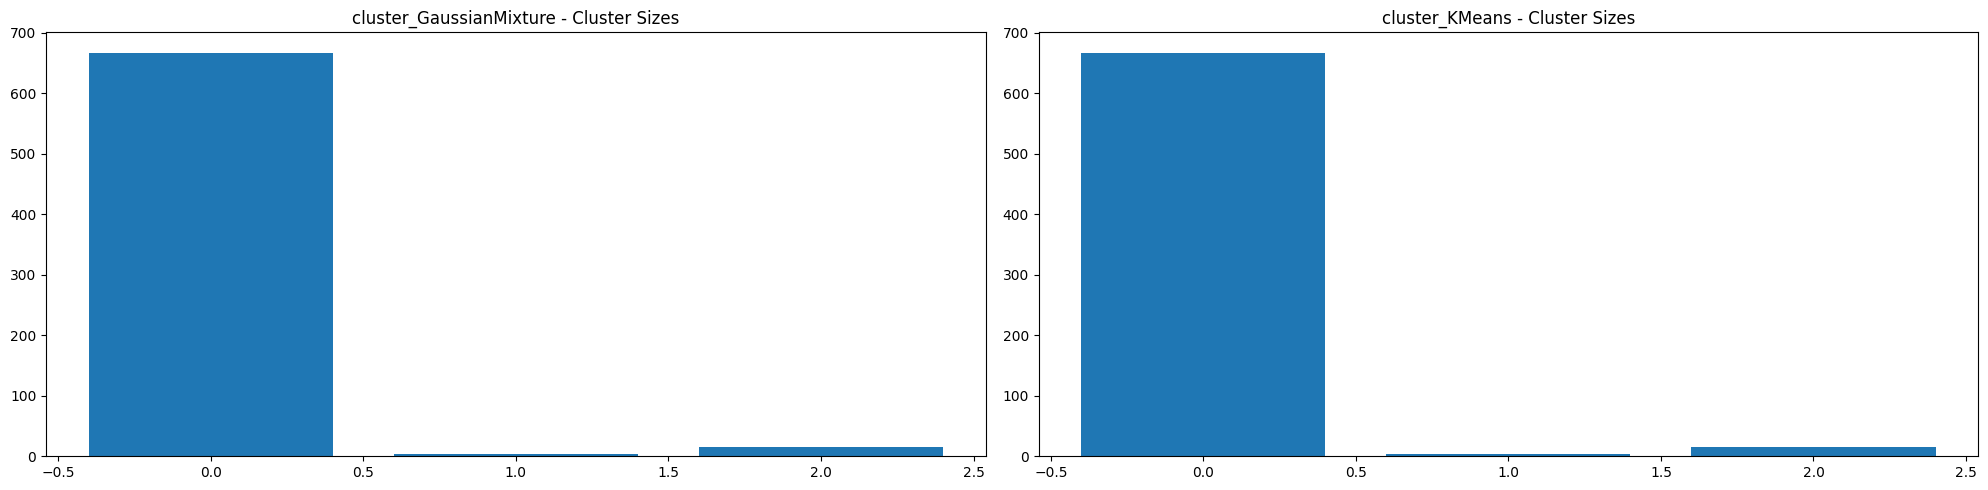

In [87]:
plt_cluster_size(df_hex_pickup_clust)

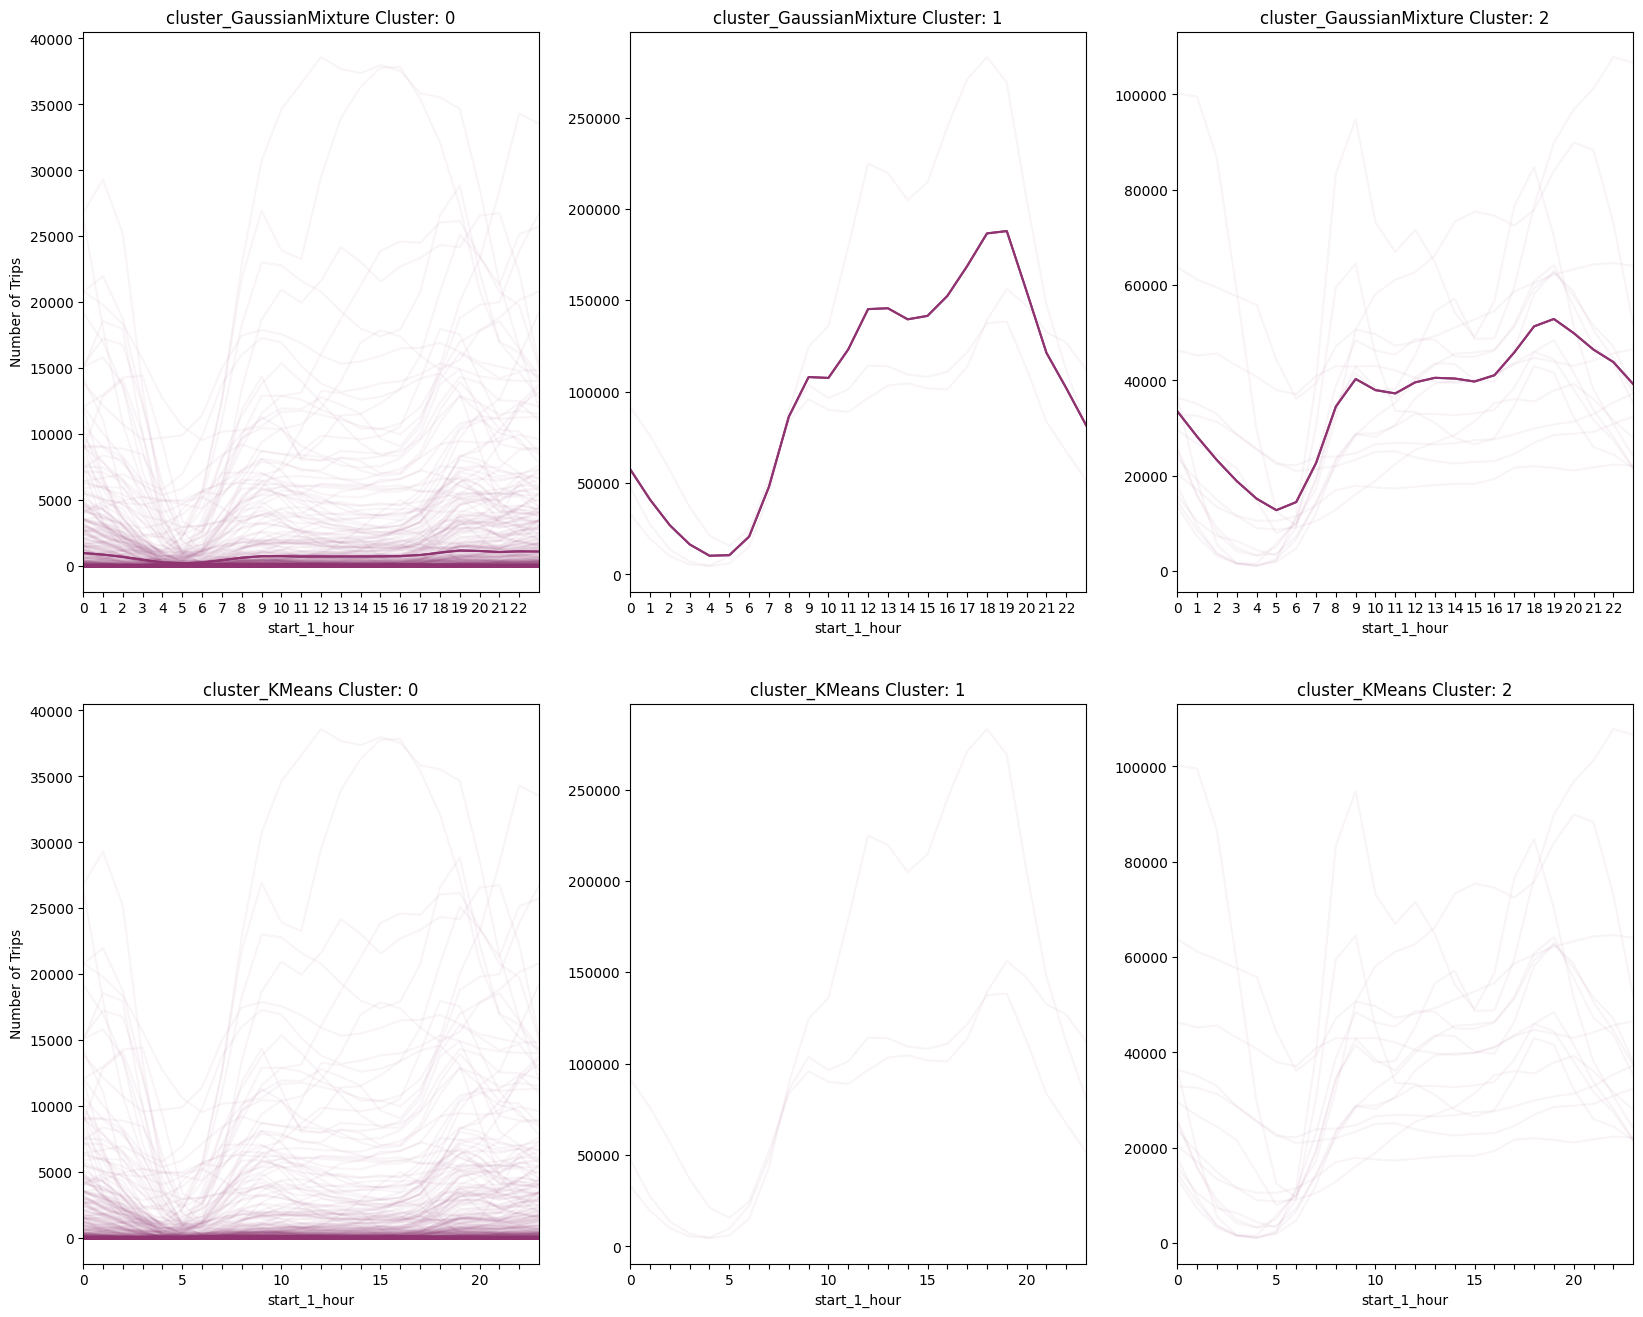

In [88]:
plt_temporal_patterns(df_hex_pickup_clust, num_cluster)

In [129]:
hex_to_map(df_hex_pickup_clust)

#### Hexagon demand clustering

We looked at how busy different areas are using hexagons. We did this by grouping hexagons based on how many rides they have. Here's how we did it:

**Gaussian Mixture Model (GMM)**

Cluster 0 (low performer) is for areas that aren't very busy. About 667 hexagons are in this group. They have fewer than 40,000 rides per hour, and there's no clear trend in demand throughout the day.

Cluster 1 (high performer is for areas that are very busy. It has only 3 hexagons. They have a lot of rides, especially in the evening around 6-7 pm, and also a bit during noon. These busy hexagons are mostly in the city center.

Cluster 2 (medium performer) is for areas that are sort of busy. Around 15 hexagons are in this group. Like Cluster 1, they get busy around 6-7 pm and a bit at noon. These hexagons are also in the city center, with one at the airport.

**K-Means Algorithm**

Cluster 0 (low performer) in K-Means is similar to GMM's Cluster 0. Around 667 hexagons are here, and they aren't very busy with less than 40,000 rides per hour. Demand doesn't follow a clear pattern during the day.

Cluster 1 (high performer) in K-Means is like GMM's Cluster 1. There are only 3 hexagons in this group, and they're really busy. They have lots of rides, especially in the evening around 6-7 pm and also a bit during noon. Most of them are in the city center.

Cluster 2 (medium performer) in K-Means is like GMM's Cluster 2. Around 15 hexagons are here, and they're somewhat busy. The pattern is the same as in Cluster 1, with busy times around 6-7 pm and at noon. They're mostly in the city center, with one at the airport.

Comparing the Results

Both GMM and K-Means show the same results. We can see different levels of busyness – high, medium, and low. The patterns are alike in both methods. One thing to note is that the airport hexagon is in the same group as the city center, even though it's not really like the other hexagons in that group. This shows that the way we grouped things is reliable and can be trusted.

### Hexagon demand clustering separated by weekend

Clustering based on same features as the hexagon clustering but additionally separated by is_weekend.

In [90]:
df_trips

ts_start_1_hour  start_month  start_weekday  start_weekday_sin  \
0        2014-05-17 10:00:00          5.0              5          -0.974928   
2        2014-05-03 23:00:00          5.0              5          -0.974928   
3        2014-05-17 01:00:00          5.0              5          -0.974928   
5        2014-05-14 09:00:00          5.0              2           0.974928   
6        2014-05-04 03:00:00          5.0              6          -0.781831   
...                      ...          ...            ...                ...   
37395431 2014-04-03 20:00:00          4.0              3           0.433884   
37395432 2014-05-13 23:00:00          5.0              1           0.781831   
37395433 2014-05-14 12:00:00          5.0              2           0.974928   
37395434 2014-05-14 12:00:00          5.0              2           0.974928   
37395435 2014-05-13 23:00:00          5.0              1           0.781831   

          start_weekday_cos  start_1_hour  start_1_hour_sin  start_1_hour_cos  \
0                 -0.222521            10      5.000000e-01         -0.866025   
2                 -0.222521            23     -2.588190e-01          0.965926   
3                 -0.222521             1      2.588190e-01          0.965926   
5                 -0.222521             9      7.071068e-01         -0.707107   
6                  0.623490             3      7.071068e-01          0.707107   
...                     ...           ...               ...               ...   
37395431          -0.900969            20     -8.660254e-01          0.500000   
37395432           0.623490            23     -2.588190e-01          0.965926   
37395433          -0.222521            12      1.224647e-16         -1.000000   
37395434          -0.222521            12      1.224647e-16         -1.000000   
37395435           0.623490            23     -2.588190e-01          0.965926   

          Trip Seconds  Trip Total     pickup_hex_9    dropoff_hex_9  \
0               1080.0       18.95  892664c1acfffff  892664c1617ffff   
2                720.0       11.45  892664c1e4fffff  892664c1e33ffff   
3                480.0       11.85  892664c114fffff  892664c163bffff   
5                180.0        5.05  892664d8ccfffff  892664d88bbffff   
6                840.0        9.85  892664c13afffff  892664c1a07ffff   
...                ...         ...              ...              ...   
37395431         900.0       11.25  892664c1607ffff  892664cac3bffff   
37395432         540.0       15.40  892664c1ecfffff  892664c1607ffff   
37395433         240.0        9.75  892664c1a8bffff  892664cad77ffff   
37395434         360.0        5.05  892664c1ed7ffff  892664c1e8fffff   
37395435         840.0       13.70  892664c1e2fffff  892664c13cfffff   

          Payment Type_Cash  Payment Type_Credit Card  dist_center_pickup  \
0                       1.0                       0.0                   2   
2                       0.0                       1.0                   5   
3                       0.0                       1.0                  12   
5                       1.0                       0.0                  49   
6                       1.0                       0.0                  10   
...                     ...                       ...                 ...   
37395431                1.0                       0.0                  25   
37395432                0.0                       1.0                   7   
37395433                0.0                       1.0                   0   
37395434                1.0                       0.0                   8   
37395435                0.0                       1.0                   3   

          dist_center_dropoff  direction  is_weekend  
0                          26         24           1  
2                           5          0           1  
3                          24         12           1  
5                          40         -9           0  
6                         

In [91]:
df_trips.columns

Index(['ts_start_1_hour', 'start_month', 'start_weekday', 'start_weekday_sin',
       'start_weekday_cos', 'start_1_hour', 'start_1_hour_sin',
       'start_1_hour_cos', 'Trip Seconds', 'Trip Total', 'pickup_hex_9',
       'dropoff_hex_9', 'Payment Type_Cash', 'Payment Type_Credit Card',
       'dist_center_pickup', 'dist_center_dropoff', 'direction', 'is_weekend'],
      dtype='object')

Feature selection

In [92]:
# separation

df_trips_wd = df_trips[df_trips.is_weekend == 0]
df_trips_we = df_trips[df_trips.is_weekend == 1]

In [93]:
# Aggregate trips based on start_hour and hexagon ID
df_hex_pickup_clust_wd = df_trips_wd.groupby(by=['start_1_hour', f'pickup_hex_{HEX_RES}']).count()['ts_start_1_hour']

# unstack to retrieve demand in each hour as feature for each hexagon and fill resulting nan values with demand of zero
df_hex_pickup_clust_wd = df_hex_pickup_clust_wd.unstack(0)
df_hex_pickup_clust_wd = df_hex_pickup_clust_wd.fillna(0)

# rename columns
df_hex_pickup_clust_wd.columns = df_hex_pickup_clust_wd.columns.map(str)

df_hex_pickup_clust_wd

start_1_hour        0     1     2     3     4     5     6      7      8  \
pickup_hex_9                                                              
89266419157ffff   4.0   0.0   1.0   4.0   3.0   3.0   3.0   12.0    5.0   
89266419493ffff   4.0   8.0   3.0   6.0   5.0   2.0   6.0    7.0    9.0   
89266419607ffff   9.0   7.0   4.0  17.0   7.0  10.0  18.0   44.0   47.0   
8926641962fffff   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0    0.0   
8926645204fffff   0.0   0.0   0.0   0.0   0.0   0.0   1.0    0.0    0.0   
...               ...   ...   ...   ...   ...   ...   ...    ...    ...   
89275936b77ffff   1.0   0.0   0.0   1.0   0.0   0.0   4.0    0.0    1.0   
89275936bb3ffff   0.0   0.0   0.0   0.0   0.0   4.0  13.0    1.0    0.0   
89275936bc7ffff   2.0   1.0   4.0   0.0   0.0  10.0  43.0   72.0  128.0   
89275936d37ffff   0.0   0.0   0.0   0.0   1.0   0.0   0.0    3.0    3.0   
89275936d53ffff  22.0  31.0  21.0  24.0  31.0  45.0  64.0  169.0   48.0   

start_1_hour         9  ...    14    15     16    17     18    19    20    21  \
pickup_hex_9            ...                                                     
89266419157ffff    9.0  ...   8.0  10.0    4.0   4.0    7.0   7.0   7.0   2.0   
89266419493ffff    7.0  ...  12.0   7.0    6.0  10.0    7.0   9.0   7.0   4.0   
89266419607ffff   96.0  ...  45.0  81.0  116.0  14.0   19.0  16.0  13.0  15.0   
8926641962fffff    0.0  ...   0.0   0.0    0.0   0.0    0.0   0.0   0.0   0.0   
8926645204fffff    0.0  ...   0.0   0.0    0.0   0.0    0.0   0.0   0.0   0.0   
...                ...  ...   ...   ...    ...   ...    ...   ...   ...   ...   
89275936b77ffff    0.0  ...   2.0   0.0    0.0   7.0    0.0   0.0   0.0   0.0   
89275936bb3ffff    0.0  ...   3.0   2.0    6.0   7.0    6.0   2.0   1.0   1.0   
89275936bc7ffff  112.0  ...  46.0  96.0  120.0  86.0  106.0  51.0  23.0   8.0   
89275936d37ffff    0.0  ...   0.0   0.0    0.0   0.0    1.0   0.0   0.0   2.0   
89275936d53ffff   40.0  ...  33.0  24.0   29.0  28.0   26.0  18.0  26.0  26.0   

start_1_hour       22    23  
pickup_hex_9                 
89266419157ffff   4.0   2.0  
89266419493ffff   2.0   2.0  
89266419607ffff  18.0   4.0  
8926641962fffff   0.0   0.0  
8926645204fffff   0.0   0.0  
...               ...   ...  
89275936b77ffff   0.0   0.0  
89275936bb3ffff   3.0   3.0  
89275936bc7ffff   2.0   2.0  
89275936d37ffff   1.0   0.0  
89275936d53ffff  26.0  34.0  

[663 rows x 24 columns]

In [94]:
# Aggregate trips based on start_hour and hexagon ID
df_hex_pickup_clust_we = df_trips_we.groupby(by=['start_1_hour', f'pickup_hex_{HEX_RES}']).count()['ts_start_1_hour']

# unstack to retrieve demand in each hour as feature for each hexagon and fill resulting nan values with demand of zero
df_hex_pickup_clust_we = df_hex_pickup_clust_we.unstack(0)
df_hex_pickup_clust_we = df_hex_pickup_clust_we.fillna(0)

# rename columns
df_hex_pickup_clust_we.columns = df_hex_pickup_clust_we.columns.map(str)

df_hex_pickup_clust_we

start_1_hour         0      1      2      3      4      5      6      7  \
pickup_hex_9                                                              
89266419157ffff    2.0    1.0    0.0    4.0    1.0    2.0    0.0    0.0   
89266419493ffff    2.0    1.0    3.0    3.0    1.0    7.0    0.0    2.0   
89266419607ffff    2.0    8.0    6.0    6.0    4.0    3.0    5.0    7.0   
8926645206bffff    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
892664520afffff  785.0  615.0  432.0  254.0  184.0  273.0  341.0  516.0   
...                ...    ...    ...    ...    ...    ...    ...    ...   
89275936b77ffff    0.0    0.0    0.0    0.0    0.0    3.0    0.0    0.0   
89275936bb3ffff    0.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0   
89275936bc7ffff    4.0    0.0    3.0    0.0    0.0    0.0    0.0    1.0   
89275936d37ffff    3.0    0.0    2.0    1.0    0.0    0.0    0.0    0.0   
89275936d53ffff   47.0   68.0   75.0   52.0   30.0   29.0   21.0   12.0   

start_1_hour         8      9  ...      14      15      16      17      18  \
pickup_hex_9                   ...                                           
89266419157ffff    1.0    2.0  ...     1.0     3.0     3.0     1.0     3.0   
89266419493ffff    3.0    2.0  ...     4.0     1.0     4.0     0.0     5.0   
89266419607ffff    7.0   11.0  ...    13.0     7.0    14.0    15.0     4.0   
8926645206bffff    0.0    0.0  ...     0.0     0.0     0.0     0.0     0.0   
892664520afffff  763.0  971.0  ...  1527.0  1512.0  1564.0  1568.0  1686.0   
...                ...    ...  ...     ...     ...     ...     ...     ...   
89275936b77ffff    0.0    0.0  ...     4.0     5.0     2.0     1.0     0.0   
89275936bb3ffff    1.0    0.0  ...     4.0     1.0     1.0     1.0     1.0   
89275936bc7ffff    4.0   12.0  ...     0.0     8.0     7.0     8.0    13.0   
89275936d37ffff    0.0    0.0  ...     0.0     4.0     0.0     0.0     1.0   
89275936d53ffff    7.0   14.0  ...    12.0    14.0     9.0    17.0    22.0   

start_1_hour         19      20      21      22      23  
pickup_hex_9                                             
89266419157ffff     2.0     1.0     0.0     0.0     0.0  
89266419493ffff     5.0     2.0     5.0     3.0     2.0  
89266419607ffff    10.0     9.0     3.0     4.0     4.0  
8926645206bffff     0.0     0.0     0.0     0.0     0.0  
892664520afffff  1716.0  2132.0  2242.0  2106.0  1984.0  
...                 ...     ...     ...     ...     ...  
89275936b77ffff     0.0     2.0     3.0     1.0     0.0  
89275936bb3ffff     0.0     0.0     3.0     0.0     0.0  
89275936bc7ffff    10.0     1.0     1.0     5.0     7.0  
89275936d37ffff     0.0     0.0     4.0     0.0     0.0  
89275936d53ffff    36.0    16.0    19.0    32.0    32.0  

[553 rows x 24 columns]

Scale encoded dataframe

In [95]:
df_hex_pickup_clust_wd_scaled = scale_df(df_hex_pickup_clust_wd)
df_hex_pickup_clust_we_scaled = scale_df(df_hex_pickup_clust_we)

Calculate the optimal number of clusters using a Grid Search

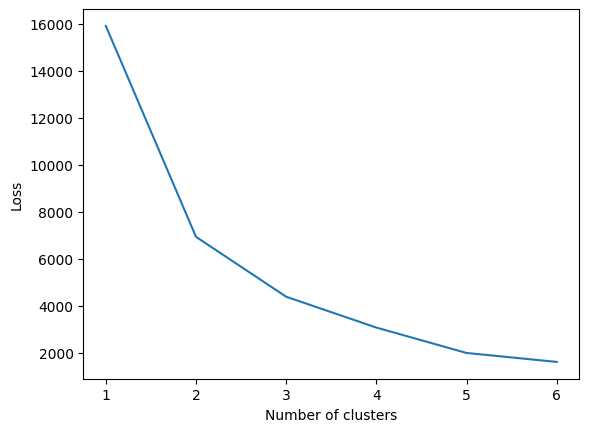

In [96]:
gridSearch(df_hex_pickup_clust_wd_scaled, 6)

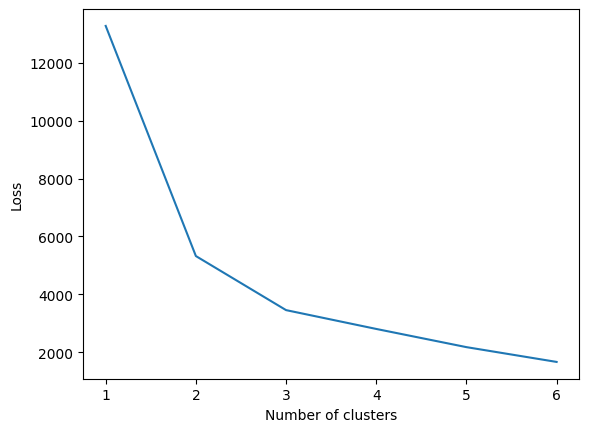

In [97]:
gridSearch(df_hex_pickup_clust_we_scaled, 6)

According to the elbow chart, the optimal number of clusters is 2. Since the first evaluation has shown that the cluster sizes vary significantly, the larger cluster needs to be seperated as well by calculating 3 clusters.

#### Fitting the models and prediction

Defining the optimal number of clusters for all models

In [98]:
num_cluster = 3

#### Gaussian Mixture Model

In [99]:
model = GaussianMixture(n_components = num_cluster, random_state=42)
fit_and_predict(model, df_hex_pickup_clust_wd_scaled, df_hex_pickup_clust_wd)

model = GaussianMixture(n_components = num_cluster, random_state=42)
fit_and_predict(model, df_hex_pickup_clust_we_scaled, df_hex_pickup_clust_we)

In [100]:
df_hex_pickup_clust_we

start_1_hour         0      1      2      3      4      5      6      7  \
pickup_hex_9                                                              
89266419157ffff    2.0    1.0    0.0    4.0    1.0    2.0    0.0    0.0   
89266419493ffff    2.0    1.0    3.0    3.0    1.0    7.0    0.0    2.0   
89266419607ffff    2.0    8.0    6.0    6.0    4.0    3.0    5.0    7.0   
8926645206bffff    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
892664520afffff  785.0  615.0  432.0  254.0  184.0  273.0  341.0  516.0   
...                ...    ...    ...    ...    ...    ...    ...    ...   
89275936b77ffff    0.0    0.0    0.0    0.0    0.0    3.0    0.0    0.0   
89275936bb3ffff    0.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0   
89275936bc7ffff    4.0    0.0    3.0    0.0    0.0    0.0    0.0    1.0   
89275936d37ffff    3.0    0.0    2.0    1.0    0.0    0.0    0.0    0.0   
89275936d53ffff   47.0   68.0   75.0   52.0   30.0   29.0   21.0   12.0   

start_1_hour         8      9  ...      15      16      17      18      19  \
pickup_hex_9                   ...                                           
89266419157ffff    1.0    2.0  ...     3.0     3.0     1.0     3.0     2.0   
89266419493ffff    3.0    2.0  ...     1.0     4.0     0.0     5.0     5.0   
89266419607ffff    7.0   11.0  ...     7.0    14.0    15.0     4.0    10.0   
8926645206bffff    0.0    0.0  ...     0.0     0.0     0.0     0.0     0.0   
892664520afffff  763.0  971.0  ...  1512.0  1564.0  1568.0  1686.0  1716.0   
...                ...    ...  ...     ...     ...     ...     ...     ...   
89275936b77ffff    0.0    0.0  ...     5.0     2.0     1.0     0.0     0.0   
89275936bb3ffff    1.0    0.0  ...     1.0     1.0     1.0     1.0     0.0   
89275936bc7ffff    4.0   12.0  ...     8.0     7.0     8.0    13.0    10.0   
89275936d37ffff    0.0    0.0  ...     4.0     0.0     0.0     1.0     0.0   
89275936d53ffff    7.0   14.0  ...    14.0     9.0    17.0    22.0    36.0   

start_1_hour         20      21      22      23  cluster_GaussianMixture  
pickup_hex_9                                                              
89266419157ffff     1.0     0.0     0.0     0.0                        1  
89266419493ffff     2.0     5.0     3.0     2.0                        1  
89266419607ffff     9.0     3.0     4.0     4.0                        1  
8926645206bffff     0.0     0.0     0.0     0.0                        1  
892664520afffff  2132.0  2242.0  2106.0  1984.0                        0  
...                 ...     ...     ...     ...                      ...  
89275936b77ffff     2.0     3.0     1.0     0.0                        1  
89275936bb3ffff     0.0     3.0     0.0     0.0                        1  
89275936bc7ffff     1.0     1.0     5.0     7.0                        1  
89275936d37ffff     0.0     4.0     0.0     0.0                        1  
89275936d53ffff    16.0    19.0    32.0    32.0                        1  

[553 rows x 25 columns]

#### KMeans

In [101]:
model = KMeans(n_clusters = num_cluster, n_init=10, init="k-means++", random_state=42)
fit_and_predict(model, df_hex_pickup_clust_wd_scaled, df_hex_pickup_clust_wd)

model = KMeans(n_clusters = num_cluster, n_init=10, init="k-means++", random_state=42)
fit_and_predict(model, df_hex_pickup_clust_we_scaled, df_hex_pickup_clust_we)

In [102]:
df_hex_pickup_clust_we

start_1_hour         0      1      2      3      4      5      6      7  \
pickup_hex_9                                                              
89266419157ffff    2.0    1.0    0.0    4.0    1.0    2.0    0.0    0.0   
89266419493ffff    2.0    1.0    3.0    3.0    1.0    7.0    0.0    2.0   
89266419607ffff    2.0    8.0    6.0    6.0    4.0    3.0    5.0    7.0   
8926645206bffff    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
892664520afffff  785.0  615.0  432.0  254.0  184.0  273.0  341.0  516.0   
...                ...    ...    ...    ...    ...    ...    ...    ...   
89275936b77ffff    0.0    0.0    0.0    0.0    0.0    3.0    0.0    0.0   
89275936bb3ffff    0.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0   
89275936bc7ffff    4.0    0.0    3.0    0.0    0.0    0.0    0.0    1.0   
89275936d37ffff    3.0    0.0    2.0    1.0    0.0    0.0    0.0    0.0   
89275936d53ffff   47.0   68.0   75.0   52.0   30.0   29.0   21.0   12.0   

start_1_hour         8      9  ...      16      17      18      19      20  \
pickup_hex_9                   ...                                           
89266419157ffff    1.0    2.0  ...     3.0     1.0     3.0     2.0     1.0   
89266419493ffff    3.0    2.0  ...     4.0     0.0     5.0     5.0     2.0   
89266419607ffff    7.0   11.0  ...    14.0    15.0     4.0    10.0     9.0   
8926645206bffff    0.0    0.0  ...     0.0     0.0     0.0     0.0     0.0   
892664520afffff  763.0  971.0  ...  1564.0  1568.0  1686.0  1716.0  2132.0   
...                ...    ...  ...     ...     ...     ...     ...     ...   
89275936b77ffff    0.0    0.0  ...     2.0     1.0     0.0     0.0     2.0   
89275936bb3ffff    1.0    0.0  ...     1.0     1.0     1.0     0.0     0.0   
89275936bc7ffff    4.0   12.0  ...     7.0     8.0    13.0    10.0     1.0   
89275936d37ffff    0.0    0.0  ...     0.0     0.0     1.0     0.0     0.0   
89275936d53ffff    7.0   14.0  ...     9.0    17.0    22.0    36.0    16.0   

start_1_hour         21      22      23  cluster_GaussianMixture  \
pickup_hex_9                                                       
89266419157ffff     0.0     0.0     0.0                        1   
89266419493ffff     5.0     3.0     2.0                        1   
89266419607ffff     3.0     4.0     4.0                        1   
8926645206bffff     0.0     0.0     0.0                        1   
892664520afffff  2242.0  2106.0  1984.0                        0   
...                 ...     ...     ...                      ...   
89275936b77ffff     3.0     1.0     0.0                        1   
89275936bb3ffff     3.0     0.0     0.0                        1   
89275936bc7ffff     1.0     5.0     7.0                        1   
89275936d37ffff     4.0     0.0     0.0                        1   
89275936d53ffff    19.0    32.0    32.0                        1   

start_1_hour     cluster_KMeans  
pickup_hex_9                     
89266419157ffff               0  
89266419493ffff               0  
89266419607ffff               0  
8926645206bffff               0  
892664520afffff               0  
...                         ...  
89275936b77ffff               0  
89275936bb3ffff               0  
89275936bc7ffff               0  
89275936d37ffff               0  
89275936d53ffff               0  

[553 rows x 26 columns]

#### Evaluation

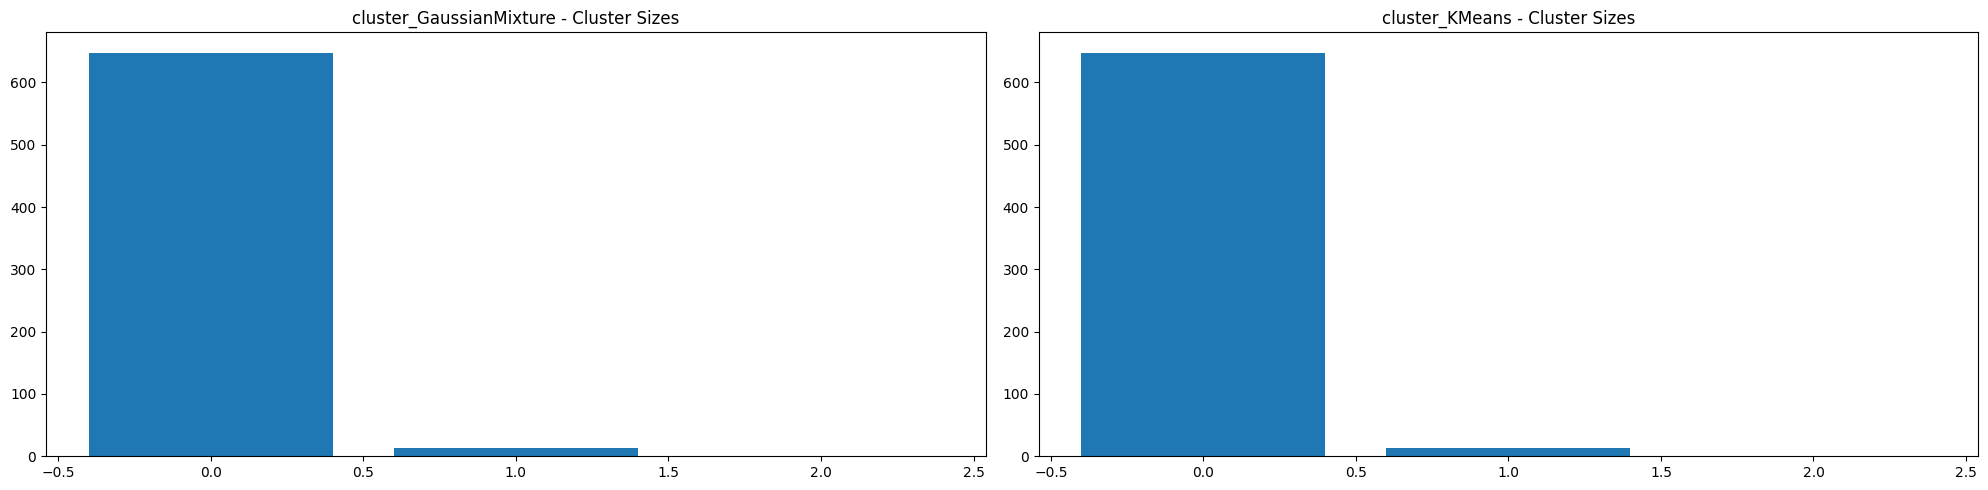

In [103]:
plt_cluster_size(df_hex_pickup_clust_wd)

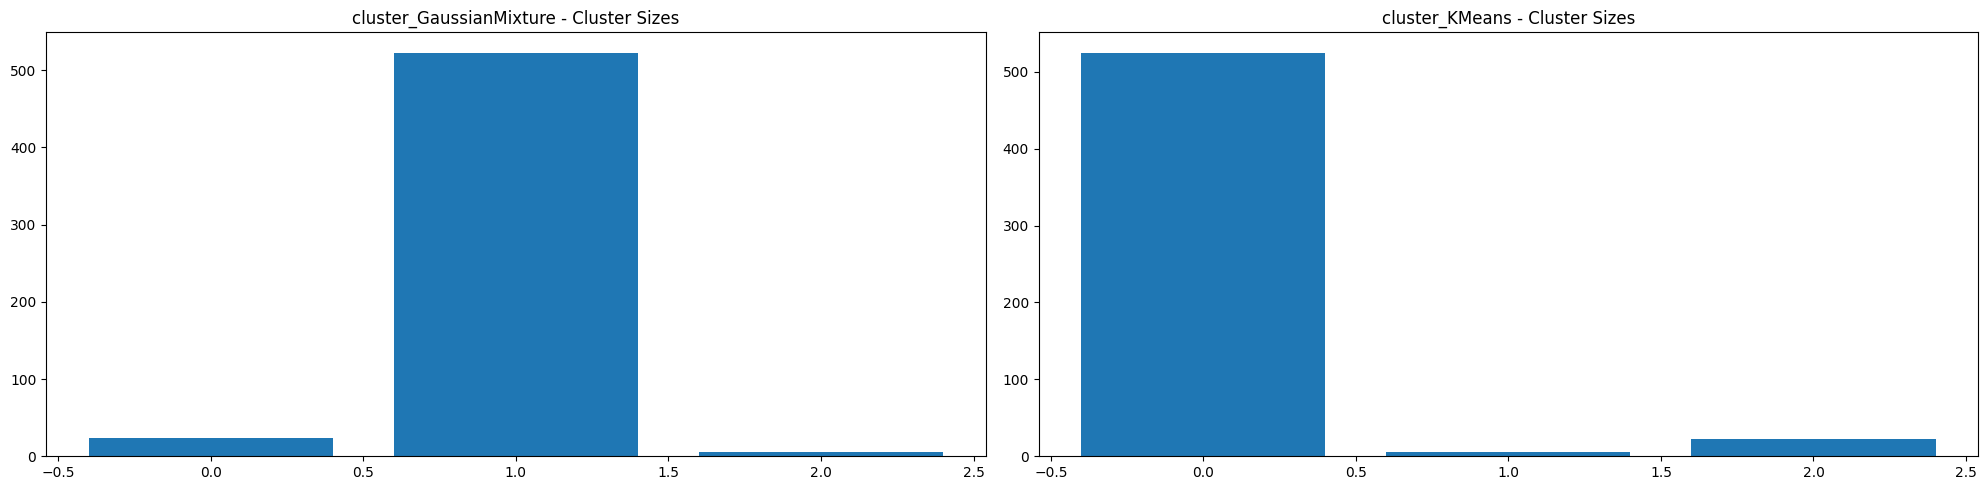

In [104]:
plt_cluster_size(df_hex_pickup_clust_we)

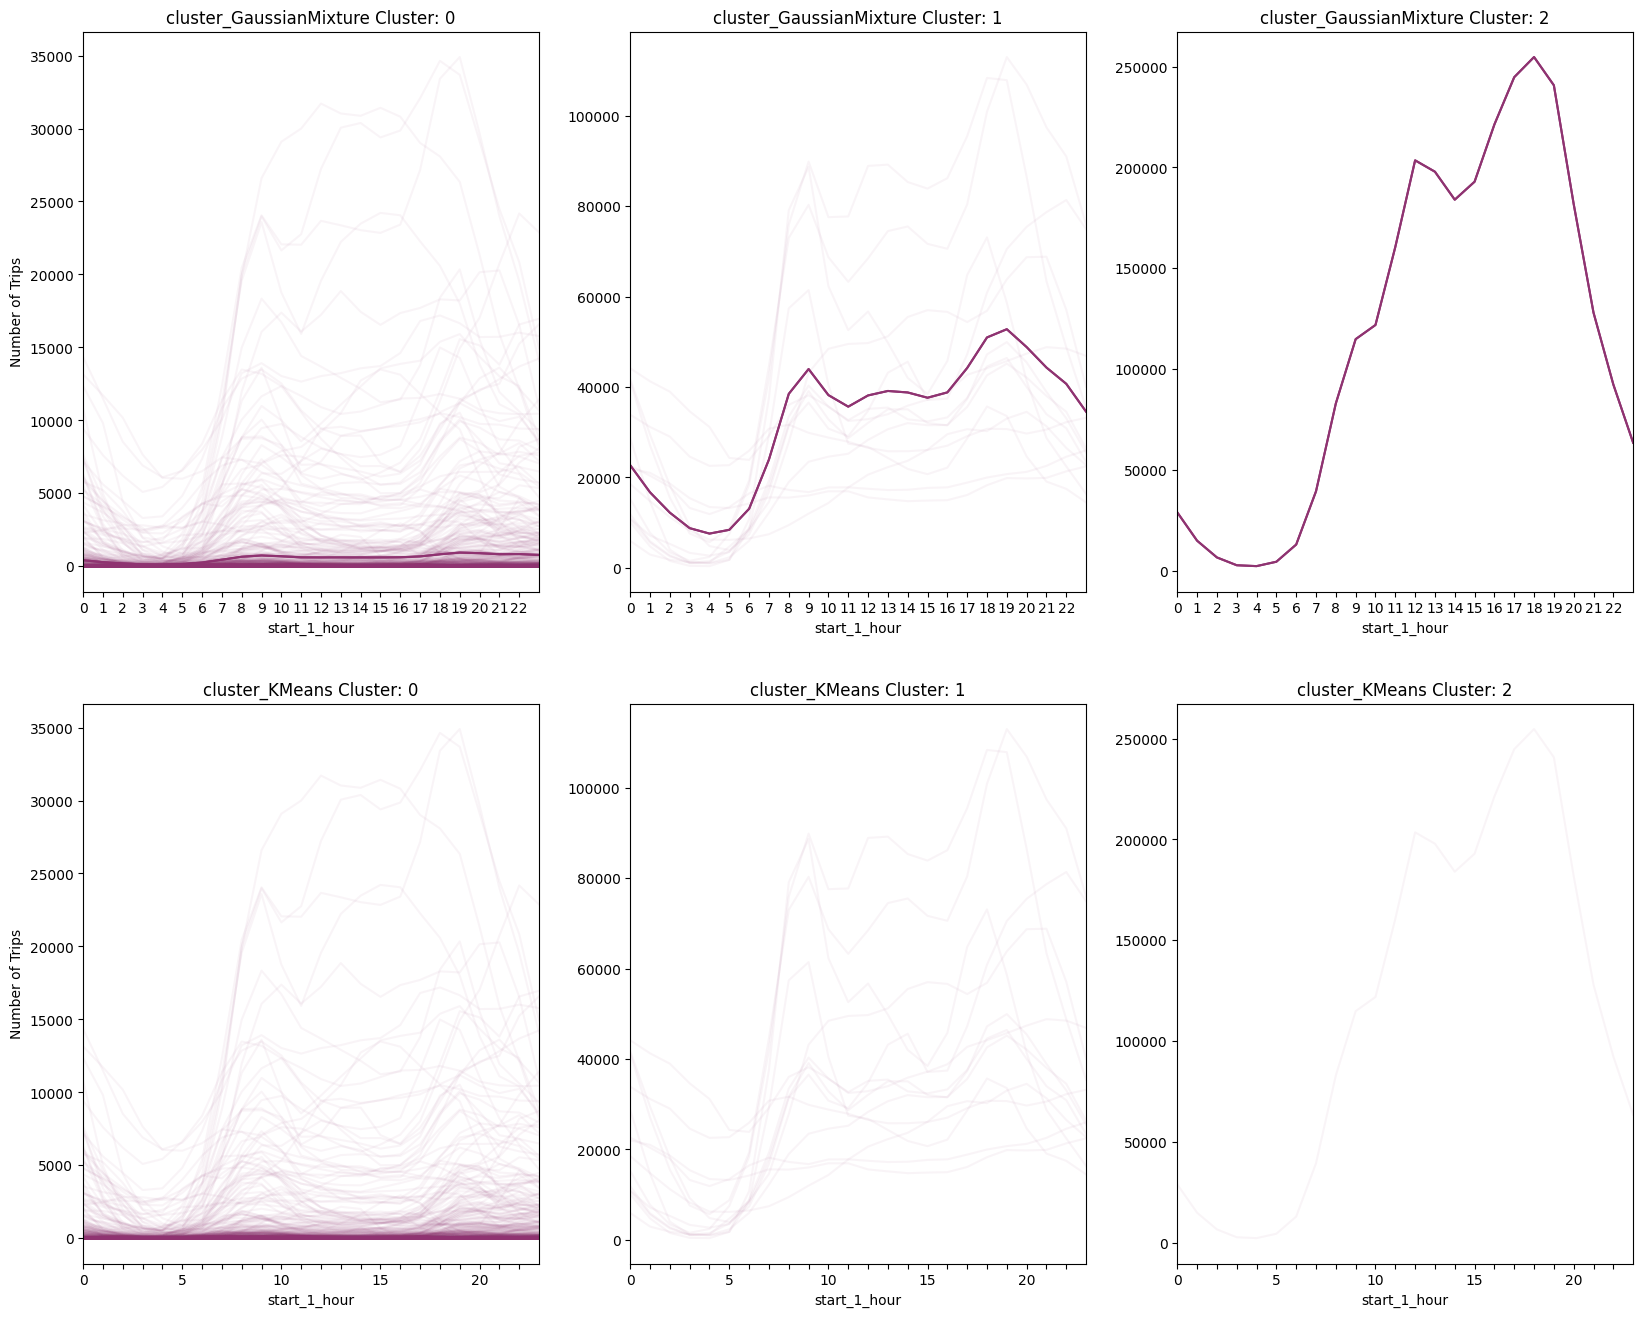

In [105]:
plt_temporal_patterns(df_hex_pickup_clust_wd, num_cluster)

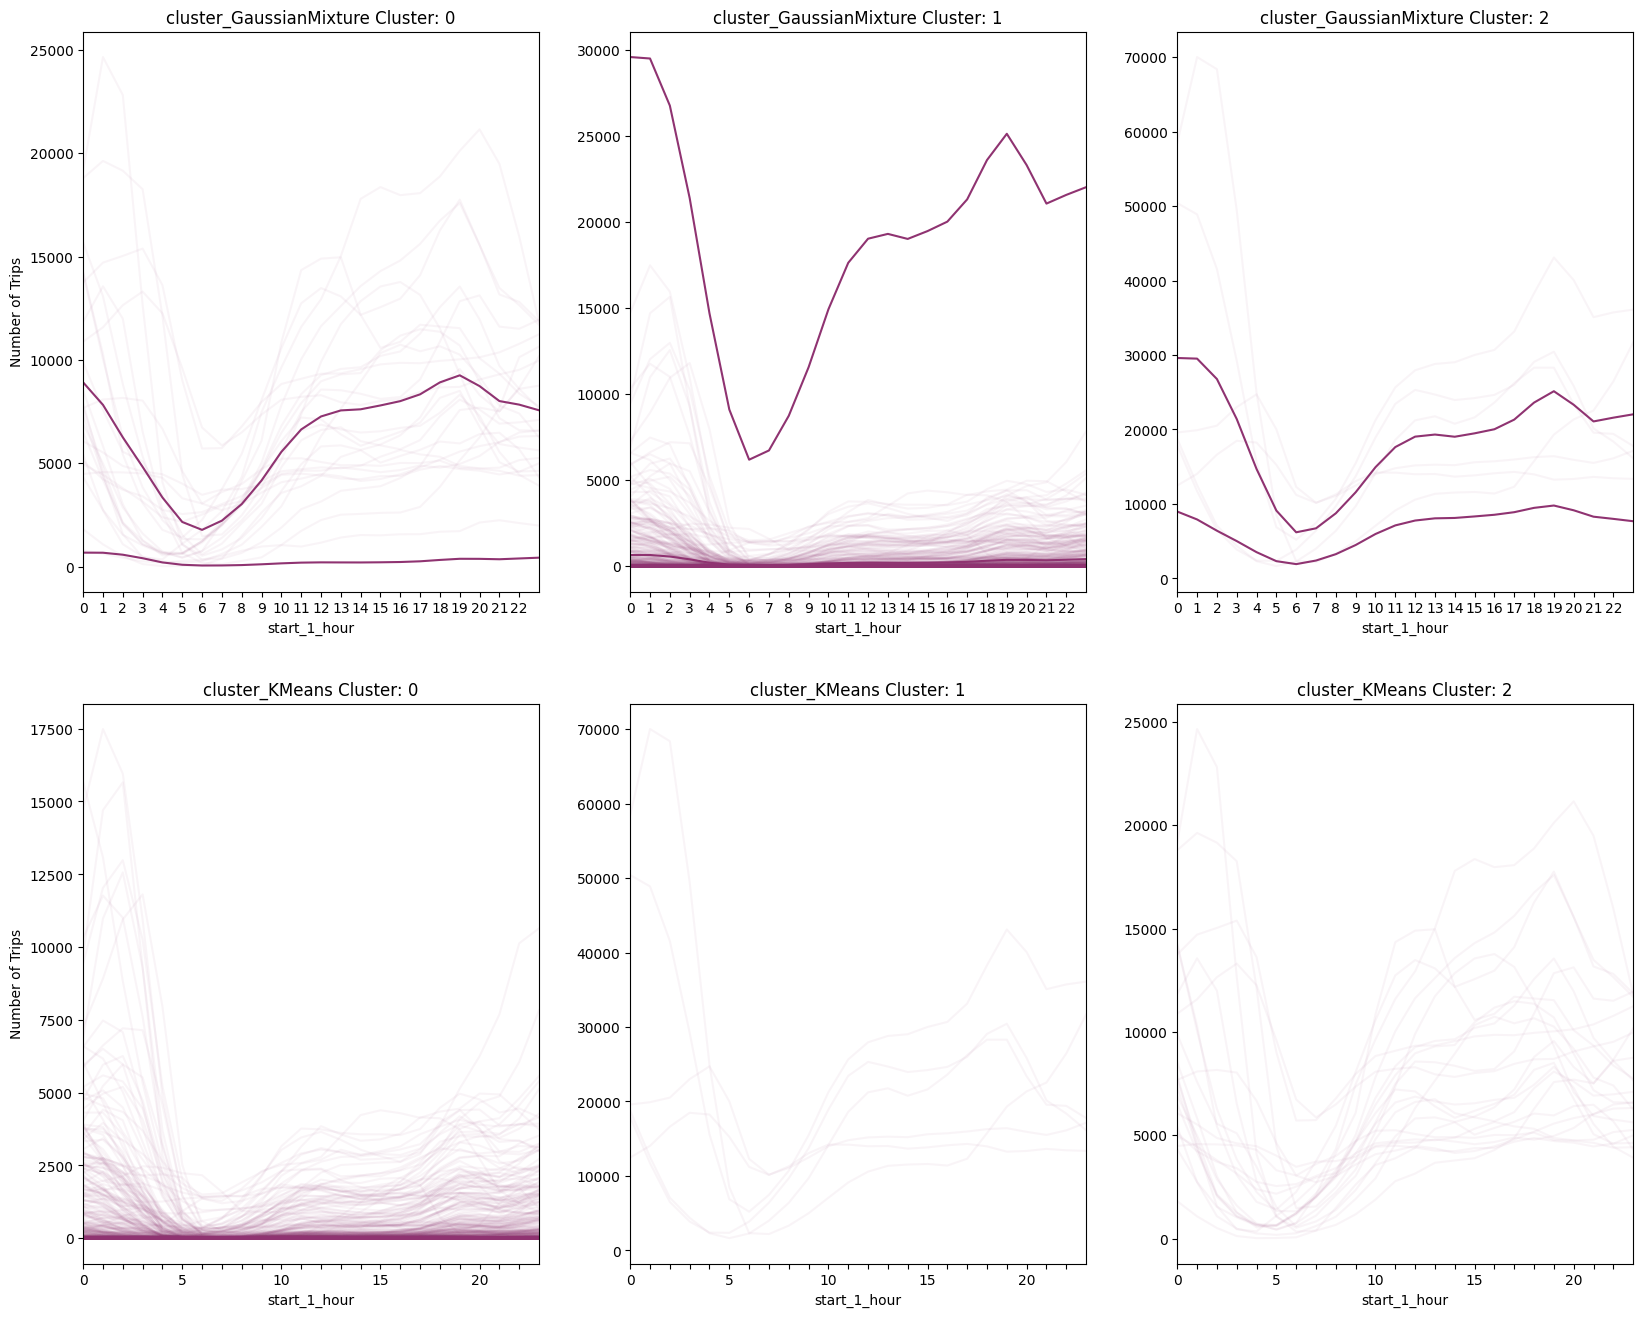

In [106]:
plt_temporal_patterns(df_hex_pickup_clust_we, num_cluster)

In [107]:
df_hex_pickup_clust_unified = df_hex_pickup_clust_wd.join(df_hex_pickup_clust_we, how='outer', lsuffix='_weekday', rsuffix='_weekend')

In [126]:
hex_to_map(df_hex_pickup_clust_unified)

### Hexagonal Demand Clustering Separated by Weekends

The outcomes closely resemble the hexagonal demand clustering methodology expounded earlier. The nature of the clusters exhibits substantial congruence. The clustering delineates discrete performance tiers across hexagons, encompassing low, medium, and high-performance categories.

Weekday distributions of areas mirror the initial approach, demonstrating a high degree of similarity. However, on weekends, discernible alterations surface within medium-performance regions. Notably, the distribution of trip origins within the city center becomes broader, suggesting a wider spatial spread.

Moreover, it becomes evident that the secondary airport situated to the south of Chicago experiences heightened arrivals during weekends compared to weekdays.

### Hexagon hotspot clustering

Clustering based demand patterns of each hexagon but enhanced by spatial information (latitude and longitude). This enables clustering based on geographical information and identifies clusters based on their locality as well.

In [109]:
df_trips

ts_start_1_hour  start_month  start_weekday  start_weekday_sin  \
0        2014-05-17 10:00:00          5.0              5          -0.974928   
2        2014-05-03 23:00:00          5.0              5          -0.974928   
3        2014-05-17 01:00:00          5.0              5          -0.974928   
5        2014-05-14 09:00:00          5.0              2           0.974928   
6        2014-05-04 03:00:00          5.0              6          -0.781831   
...                      ...          ...            ...                ...   
37395431 2014-04-03 20:00:00          4.0              3           0.433884   
37395432 2014-05-13 23:00:00          5.0              1           0.781831   
37395433 2014-05-14 12:00:00          5.0              2           0.974928   
37395434 2014-05-14 12:00:00          5.0              2           0.974928   
37395435 2014-05-13 23:00:00          5.0              1           0.781831   

          start_weekday_cos  start_1_hour  start_1_hour_sin  start_1_hour_cos  \
0                 -0.222521            10      5.000000e-01         -0.866025   
2                 -0.222521            23     -2.588190e-01          0.965926   
3                 -0.222521             1      2.588190e-01          0.965926   
5                 -0.222521             9      7.071068e-01         -0.707107   
6                  0.623490             3      7.071068e-01          0.707107   
...                     ...           ...               ...               ...   
37395431          -0.900969            20     -8.660254e-01          0.500000   
37395432           0.623490            23     -2.588190e-01          0.965926   
37395433          -0.222521            12      1.224647e-16         -1.000000   
37395434          -0.222521            12      1.224647e-16         -1.000000   
37395435           0.623490            23     -2.588190e-01          0.965926   

          Trip Seconds  Trip Total     pickup_hex_9    dropoff_hex_9  \
0               1080.0       18.95  892664c1acfffff  892664c1617ffff   
2                720.0       11.45  892664c1e4fffff  892664c1e33ffff   
3                480.0       11.85  892664c114fffff  892664c163bffff   
5                180.0        5.05  892664d8ccfffff  892664d88bbffff   
6                840.0        9.85  892664c13afffff  892664c1a07ffff   
...                ...         ...              ...              ...   
37395431         900.0       11.25  892664c1607ffff  892664cac3bffff   
37395432         540.0       15.40  892664c1ecfffff  892664c1607ffff   
37395433         240.0        9.75  892664c1a8bffff  892664cad77ffff   
37395434         360.0        5.05  892664c1ed7ffff  892664c1e8fffff   
37395435         840.0       13.70  892664c1e2fffff  892664c13cfffff   

          Payment Type_Cash  Payment Type_Credit Card  dist_center_pickup  \
0                       1.0                       0.0                   2   
2                       0.0                       1.0                   5   
3                       0.0                       1.0                  12   
5                       1.0                       0.0                  49   
6                       1.0                       0.0                  10   
...                     ...                       ...                 ...   
37395431                1.0                       0.0                  25   
37395432                0.0                       1.0                   7   
37395433                0.0                       1.0                   0   
37395434                1.0                       0.0                   8   
37395435                0.0                       1.0                   3   

          dist_center_dropoff  direction  is_weekend  
0                          26         24           1  
2                           5          0           1  
3                          24         12           1  
5                          40         -9           0  
6                         

In [110]:
df_trips.columns

Index(['ts_start_1_hour', 'start_month', 'start_weekday', 'start_weekday_sin',
       'start_weekday_cos', 'start_1_hour', 'start_1_hour_sin',
       'start_1_hour_cos', 'Trip Seconds', 'Trip Total', 'pickup_hex_9',
       'dropoff_hex_9', 'Payment Type_Cash', 'Payment Type_Credit Card',
       'dist_center_pickup', 'dist_center_dropoff', 'direction', 'is_weekend'],
      dtype='object')

Feature selection

In [111]:
# Aggregate trips based hexagon ID
df_hex_demand_clust = pd.DataFrame(df_trips.groupby(by=[f'pickup_hex_{HEX_RES}']).count()['ts_start_1_hour'])
df_hex_demand_clust.rename(columns={'ts_start_1_hour':'demand'}, inplace=True)
df_hex_demand_clust['hex'] =  df_hex_demand_clust.index

# add geometry
df_hex_demand_clust['geometry_lat'] = df_hex_demand_clust['hex'].apply(lambda id: h3.cell_to_latlng(id)[0])
df_hex_demand_clust['geometry_lon'] = df_hex_demand_clust['hex'].apply(lambda id: h3.cell_to_latlng(id)[1])

df_hex_demand_clust.drop(columns='hex', inplace=True)


df_hex_demand_clust

demand  geometry_lat  geometry_lon
pickup_hex_9                                       
89266419157ffff     163     41.662549    -87.539416
89266419493ffff     238     41.706603    -87.536490
89266419607ffff    1020     41.690631    -87.570871
8926641962fffff       1     41.682526    -87.570363
8926645204fffff       1     41.794339    -87.791464
...                 ...           ...           ...
89275936b77ffff      42     41.972514    -87.843377
89275936bb3ffff      81     41.980256    -87.828257
89275936bc7ffff    1394     41.983565    -87.842715
89275936d37ffff      36     41.996368    -87.793771
89275936d53ffff    1533     42.007181    -87.813015

[685 rows x 3 columns]

Scale encoded dataframe

In [112]:
df_hex_demand_clust_scaled = scale_df(df_hex_demand_clust)

Calculate the optimal number of clusters using a Grid Search

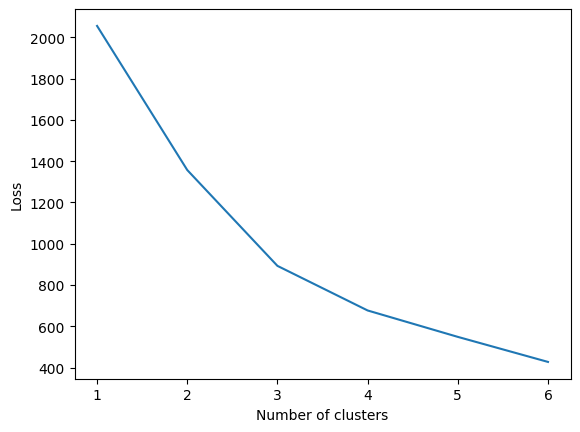

In [113]:
gridSearch(df_hex_demand_clust_scaled, 6)

According to the elbow chart, the optimal number of clusters is 2.

#### Fitting the models and prediction

Defining the optimal number of clusters for all models

In [114]:
num_cluster = 3

#### Gaussian Mixture Model

In [115]:
model = GaussianMixture(n_components = num_cluster, random_state=42)
fit_and_predict(model, df_hex_demand_clust_scaled, df_hex_demand_clust)

In [116]:
df_hex_demand_clust

demand  geometry_lat  geometry_lon  cluster_GaussianMixture
pickup_hex_9                                                                
89266419157ffff     163     41.662549    -87.539416                        1
89266419493ffff     238     41.706603    -87.536490                        1
89266419607ffff    1020     41.690631    -87.570871                        1
8926641962fffff       1     41.682526    -87.570363                        1
8926645204fffff       1     41.794339    -87.791464                        1
...                 ...           ...           ...                      ...
89275936b77ffff      42     41.972514    -87.843377                        1
89275936bb3ffff      81     41.980256    -87.828257                        1
89275936bc7ffff    1394     41.983565    -87.842715                        1
89275936d37ffff      36     41.996368    -87.793771                        1
89275936d53ffff    1533     42.007181    -87.813015                        1

[685 rows x 4 columns]

In [117]:
feature_distribution(df_hex_demand_clust, f'cluster_{model.__class__.__name__}')

demand                geometry_lat            \
                                  mean            std         mean       std   
cluster_GaussianMixture                                                        
0                         54895.085859  109573.827290    41.917702  0.055001   
1                           251.032397     506.095675    41.861647  0.089416   
2                        880041.916667  692761.962461    41.894282  0.017630   

                        geometry_lon           cluster_size first_demand  \
                                mean       std                             
cluster_GaussianMixture                                                    
0                         -87.671413  0.043377          198       106762   
1                         -87.689773  0.065461          463            1   
2                         -87.631653  0.014080           24       339916   

                        first_geometry_lat first_geometry_lon  
                                                               
cluster_GaussianMixture                                        
0                                41.792284         -87.768647  
1                                41.662549         -87.539416  
2                                41.913943         -87.630426

#### KMeans

In [118]:
model = KMeans(n_clusters = num_cluster, n_init=10, init="k-means++", random_state=42)
fit_and_predict(model, df_hex_demand_clust_scaled, df_hex_demand_clust)

In [119]:
df_hex_demand_clust

demand  geometry_lat  geometry_lon  cluster_GaussianMixture  \
pickup_hex_9                                                                   
89266419157ffff     163     41.662549    -87.539416                        1   
89266419493ffff     238     41.706603    -87.536490                        1   
89266419607ffff    1020     41.690631    -87.570871                        1   
8926641962fffff       1     41.682526    -87.570363                        1   
8926645204fffff       1     41.794339    -87.791464                        1   
...                 ...           ...           ...                      ...   
89275936b77ffff      42     41.972514    -87.843377                        1   
89275936bb3ffff      81     41.980256    -87.828257                        1   
89275936bc7ffff    1394     41.983565    -87.842715                        1   
89275936d37ffff      36     41.996368    -87.793771                        1   
89275936d53ffff    1533     42.007181    -87.813015                        1   

                 cluster_KMeans  
pickup_hex_9                     
89266419157ffff               2  
89266419493ffff               2  
89266419607ffff               2  
8926641962fffff               2  
8926645204fffff               0  
...                         ...  
89275936b77ffff               0  
89275936bb3ffff               0  
89275936bc7ffff               0  
89275936d37ffff               0  
89275936d53ffff               0  

[685 rows x 5 columns]

In [120]:
feature_distribution(df_hex_demand_clust, f'cluster_{model.__class__.__name__}')

demand                geometry_lat            \
                        mean            std         mean       std   
cluster_KMeans                                                       
0               2.469394e+04   72485.524548    41.928753  0.049430   
1               1.429497e+06  715912.353202    41.903442  0.030976   
2               2.361243e+04   98142.460115    41.789054  0.051613   

               geometry_lon           cluster_size first_demand  \
                       mean       std                             
cluster_KMeans                                                    
0                -87.710208  0.049169          432            1   
1                -87.657566  0.082234           11      1019969   
2                -87.633972  0.043108          242            1   

               first_geometry_lat first_geometry_lon  
                                                      
cluster_KMeans                                        
0                       41.794339         -87.791464  
1                       41.945618         -87.656641  
2                       41.662549         -87.539416

#### Evaluation

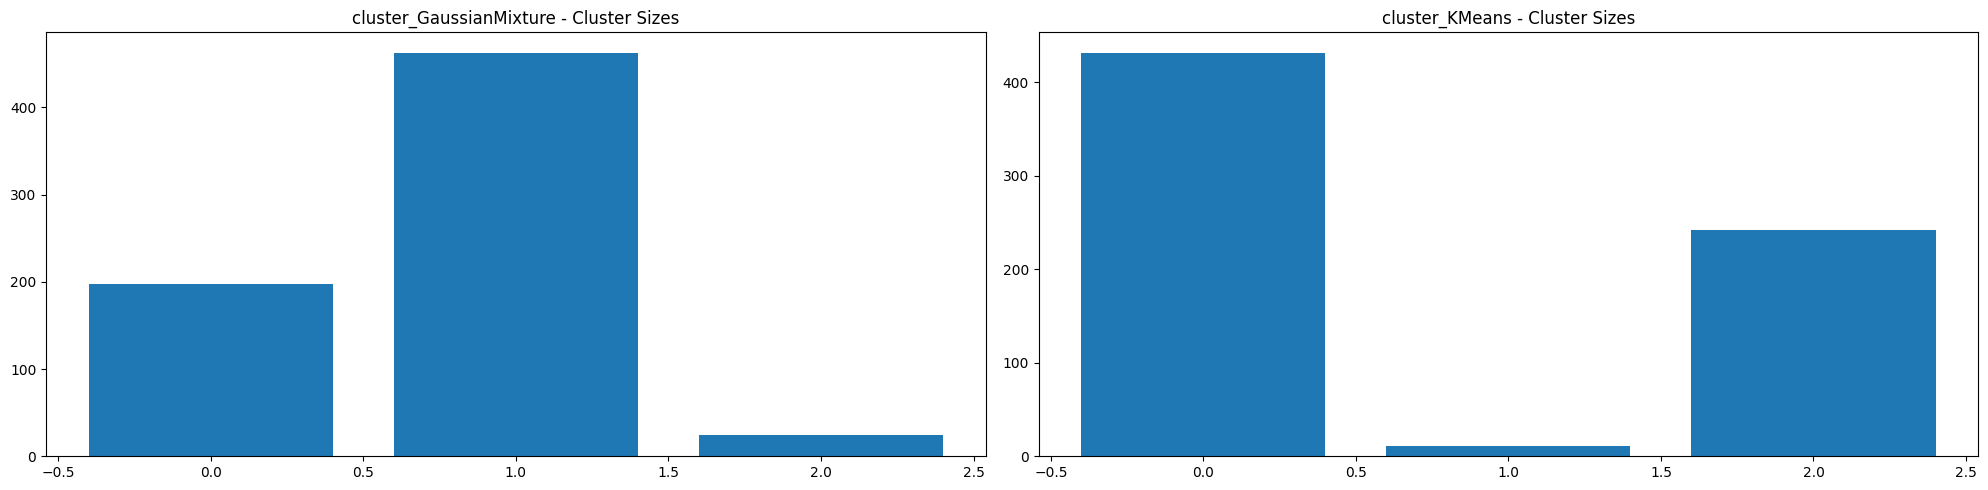

In [121]:
plt_cluster_size(df_hex_demand_clust)

In [128]:
hex_to_map(df_hex_demand_clust)

#### Hexagon Hotspot Clustering Analysis

Incorporating spatial dimensions, the Hexagon Hotspot Clustering employs proximity and demand patterns for effective grouping of areas. This approach capitalizes on geographical coordinates (latitude and longitude) to amalgamate hexagons with analogous demand trends and spatial adjacency.

**Gaussian Mixture Model (GMM)**

Cluster 0, characterized as medium performers, encompasses 198 instances. This cluster exhibits an average ride count of 54,895.09. Predominantly situated in the northern sector of Chicago, it demonstrates a coherent spatial distribution.

Cluster 1 signifies low performers, comprising 463 instances with an average ride count of 251.03. This cluster predominantly resides in the southwestern part of Chicago, exhibiting a distinct spatial pattern.

Cluster 2 denotes high performers with 24 instances and an average ride count of 880,041. Positioned within the city center, this cluster showcases a broader spatial dispersion compared to hexagon-based clustering.

**K-Means Algorithm**

Cluster 0, designated as "other hexagons in the north," encapsulates 432 instances. These hexagons exhibit an average ride count of 24,693. They are primarily concentrated in the northern realm of Chicago, with evident spatial separation.

Cluster 1, titled "high performer city center," comprises 11 instances with an average ride count of 1,429,497. This cluster is situated within the city center, emphasizing its bustling nature.

Cluster 2, identified as "other hexagons in the south," encompasses 242 instances. These hexagons, with an average ride count of 23,642, distinctly occupy the southern domain of Chicago. Spatial differentiation is vividly pronounced.

**Comparative Insights**

Comparing Gaussian Mixture Model (GMM) and K-Means methodologies, divergent outcomes arise. While GMM manifests a more nuanced grouping based on locality and demand, K-Means employs a stricter segregation approach. The high-performing cluster within the city center resonates with hexagon-based clustering.

Spatial information holds heightened relevance for lower-performing clusters. A conspicuous dichotomy is observed in the northern and southern sectors of Chicago. Notably, K-Means evinces a conspicuous spatial distinction with distinct and non-overlapping clusters.

This comparative analysis accentuates the varying dynamics between soft and hard clustering. GMM underscores locality and demand amalgamation, whereas K-Means accentuates spatial separation. The insights thus extracted further underscore the significance of spatial dimensions in understanding area-specific demand dynamics.

# Conclusion

#### Comparison of Soft and Hard Clustering Approaches

In the realm of cluster analysis, the utilization of both soft and hard clustering methodologies has been instrumental in gaining insights into various aspects of trip behaviors and demand patterns. Specifically, the Gaussian Mixture Model (GMM) and K-Means have been employed to unravel distinctive trends across different clustering scenarios.

**Trip Clustering: Gaussian Mixture Model vs. K-Means**

The examination of trip clustering through Gaussian Mixture Model and K-Means reveals striking similarities in their outcomes. Across both methods, clusters are consistently identified based on factors like the nature of trips, their duration, and spatial characteristics. Minor variations in cluster sizes are observed, which can be attributed to the inherent differences in the clustering algorithms.

Notably, a clear distinction emerges between weekend and weekday trips in both methodologies, demonstrating the efficacy of both GMM and K-Means in capturing temporal dynamics. Furthermore, the distinction between long and short rides remains consistent, underscoring the robustness of both approaches.

**Trip/Customer Clustering: Gaussian Mixture Model vs. K-Means**

In the realm of trip/customer clustering, the application of GMM and K-Means also yields comparable outcomes. The clusters generated align closely, demonstrating their stability across distinct methods. Differences in cluster sizes are minimal, reaffirming the reliability of both methodologies.

GMM effectively distinguishes between cheaper non-card payment rides and pricier card payment rides. This differentiation aligns with the objective of the analysis, highlighting the success of soft clustering in capturing nuanced variations within the data. The absence of significant weekday influence further underscores the congruence between the two approaches.

**Weather-Based Clustering: Gaussian Mixture Model vs. K-Means**

Turning to weather-based clustering, both GMM and K-Means again produce similar results. While some discrepancies in cluster sizes emerge, they do not significantly impact the overarching findings. Interestingly, weather conditions appear to have no substantial influence on clustering outcomes, as the patterns remain consistent irrespective of climatic changes.

**Hexagon Demand Clustering: Gaussian Mixture Model vs. K-Means**

In the context of hexagon demand clustering, GMM and K-Means exhibit a similar capacity for capturing demand patterns. Both approaches group hexagons based on demand characteristics, yielding clusters that are aligned in terms of high, medium, and low performance. The presence of an airport hexagon in the cluster, despite its lack of spatial dependency, further highlights the commonalities between the two methods.

**Hexagon Hotspot Clustering: A Spatial Perspective**

Shifting focus to hexagon hotspot clustering, spatiality assumes a pivotal role in both soft and hard clustering. Both GMM and K-Means identify spatially coherent clusters based on demand patterns. The distinction between medium, low, and high-performing hexagons persists, with subtle spatial variations. GMM tends to incorporate spatiality with a softer boundary, while K-Means employs a more rigid spatial separation.

**Concluding Remarks**

In conclusion, the application of both soft clustering, exemplified by Gaussian Mixture Model, and hard clustering, as exemplified by K-Means, has yielded consistent and reliable results across various analytical dimensions. While subtle differences and nuances exist, the overall patterns and trends remain remarkably congruent. The interplay between the approaches underscores the robustness of both methods in extracting meaningful insights from complex datasets, facilitating a comprehensive understanding of the underlying dynamics.